In [1]:
import os
import sys
import random
import time
from random import seed, randint
import argparse
import platform
from datetime import datetime
import imp
import numpy as np
import fileinput
from itertools import product
import pandas as pd
from scipy.interpolate import griddata
from scipy.interpolate import interp2d
import seaborn as sns
from os import listdir

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import griddata
import matplotlib as mpl
sys.path.insert(0,'/Users/weilu/Research/opt_server/')
# from notebookFunctions import *
# from .. import notebookFunctions
from Bio.PDB.Polypeptide import one_to_three
from Bio.PDB.Polypeptide import three_to_one
from Bio.PDB.PDBParser import PDBParser
from pyCodeLib import *
from small_script.myFunctions import *
from collections import defaultdict
%matplotlib inline
# plt.rcParams['figure.figsize'] = (10,6.180)    #golden ratio
# %matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
plt.rcParams['figure.figsize'] = 0.5 * np.array([16.18033, 10])    #golden ratio
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['figure.dpi'] = 100
plt.rcParams.update({'font.size': 22})

In [3]:
figureFolder = "/Users/weilu/Dropbox/openAWSEM/figures/"

In [4]:
parser = PDBParser()

In [5]:
def get_cys_info(fileLocation):
    s = parser.get_structure("X", fileLocation)
    cys_bonds = []
    for model, m in enumerate(s.get_models()):
        all_res = list(m.get_residues())
        n = len(all_res)
        for i in range(n):
            res1 = all_res[i]
            if res1.resname != "CYS":
                continue
            for j in range(i+1, n):
                res2 = all_res[j]
                if res2.resname != "CYS":
                    continue
                r = res1["CB"] - res2["CB"]
                if r < 4.5:
                    cys_bonds.append([model, i, j, r])
                    # print(i, j, r)
    a = pd.DataFrame(cys_bonds, columns=["model", "i", "j", "r"])
    # a.to_csv("cys_bonds.csv")
    return a
def correct_fraction(native_cys_bond, prediction_cys_bond):
    # FN, TP
    TP = FN = FP = 0
    native_cys_bond["pair"] = native_cys_bond["i"].astype(str) + "_" + native_cys_bond["j"].astype(str)
    native_pair_list = native_cys_bond["pair"].to_list()

    prediction_cys_bond["pair"] = prediction_cys_bond["i"].astype(str) + "_" + prediction_cys_bond["j"].astype(str)
    prediction_pair_list = prediction_cys_bond["pair"].to_list()

    for native_pair in native_pair_list:
        if native_pair in prediction_pair_list:
            TP += 1
        else:
            FN += 1
    # FP,
    for prediction_pair in prediction_pair_list:
        if prediction_pair not in native_pair_list:
            FP += 1
    return TP, FN, FP

def correct_fraction_v2(native_cys_bond, prediction_cys_bond):
    TP, FN, FP = correct_fraction(native_cys_bond, prediction_cys_bond)
    f = TP/(TP+FN+FP)
    return f, TP, FN, FP


def correct_fraction_v3(prediction_cys_bond, native_cys_bond=None):
    TP, FN, FP = correct_fraction(native_cys_bond, prediction_cys_bond)
    f = TP/(TP+FN+FP)
    return pd.DataFrame([[f, TP, FN, FP]], columns=["fraction", "TP", "FN", "FP"])


In [6]:

# data = pd.read_csv("/Users/weilu/Research/data/openMM/six_proteins_run2_single_timeStep2_lesser_frag_06-17.csv", index_col=0)
# # data = pd.read_csv("/Users/weilu/Research/data/openMM/six_proteins_run2_single_timeStep2_lesser_frag_06-16.csv", index_col=0)

# a = pd.read_csv("/Users/weilu/Dropbox/openAWSEM/data/length_info_jun10.csv", index_col=0)
# a = a.sort_values("Length").reset_index(drop=True)
# data = data.merge(a, on="Protein")

# # a = a.append({'Protein':'1ppb_H', 'Length':259}, ignore_index=True)
# # a = a.sort_values("Length").reset_index(drop=True)
# # a.to_csv("/Users/weilu/Dropbox/openAWSEM/data/length_info_jun10.csv")

# pdb_list = ["1ppb_H", "1lmm", "1tcg", "1hn4_A", "1fs3", "1bpi"]
# d_list =[]
# for pdb in pdb_list:
#     t = pd.read_csv(f"/Users/weilu/Research/data/openMM/{pdb}_cys_06_17.csv")
#     d_list.append(t)
# d_cys = pd.concat(d_list).reset_index(drop=True)
# d_cys["Steps"] = d_cys["model"] + 2
# data.Submode = data.Submode.astype(int)
# data = data.merge(d_cys, how='left', on=["Steps", "Protein", "Submode", "Run"])
# data["fraction"] = data["fraction"].fillna(0)

# data.to_csv("/Users/weilu/Research/data/openMM/disulfide_jun17.csv")

data = pd.read_csv("/Users/weilu/Research/data/openMM/disulfide_jun17.csv", index_col=0)

/Users/weilu/anaconda/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [7]:
data["Protein"].unique()

array(['1hn4_A', '1ppb_H', '1lmm', '1tcg', '1fs3', '1bpi'], dtype=object)

In [8]:
# data = data.query("Run < 10").reset_index(drop=True)

In [9]:
# scheme_dic = {"330":"k_0", "331":"k_1", "332":"k_2", "333":"k_5", "3300":"original"}
scheme_dic = {"330":"k=0", "331":"k=1", "332":"k=2", "333":"k=5", "3300":"Standard AWSEM"}
data["Submode"] = data["Submode"].astype(str)
data["Scheme"] = data["Submode"].apply(lambda x: scheme_dic[x])
selected = data.query("Steps > 2200 and Protein != '1hn4'").sort_values("Q").groupby(["Protein", "Submode", "Run"]).tail(1)


# a = a.query("Protein != '1hn4'").reset_index(drop=True)
# selected.Protein = pd.Categorical(selected.Protein, categories=a.Protein, ordered=True)

In [10]:
# selected.to_csv("/Users/weilu/Research/server/jun_week3_2020/disulfide_bond/selected_jun17.csv")

In [11]:
selected.query("Protein =='1lmm' and Submode=='332'")

,Steps,Q,Rg,Backbone,Rama,Contact,Fragment,Membrane,ER,TBM_Q,...,Submode,Length,Scheme,Unnamed: 0.1,model,level_4,fraction,TP,FN,FP
667832,2300,0.58,9.83,120.35,-110.38,-54.34,-66.76,0.0,0.0,0.0,...,332,40,k=2,124073.0,2298.0,0.0,0.250000,1.0,2.0,1.0
697793,2237,0.58,9.44,135.87,-108.87,-63.56,-75.89,0.0,0.0,0.0,...,332,40,k=2,119338.0,2235.0,0.0,0.666667,2.0,1.0,0.0
670381,2347,0.59,9.86,122.83,-119.28,-55.75,-69.55,0.0,0.0,0.0,...,332,40,k=2,127619.0,2345.0,0.0,0.333333,1.0,2.0,0.0
693032,2480,0.59,9.83,119.31,-111.04,-62.61,-75.23,0.0,0.0,0.0,...,332,40,k=2,137799.0,2478.0,0.0,0.000000,0.0,3.0,1.0
685340,2294,0.62,9.84,111.07,-126.12,-62.25,-68.29,0.0,0.0,0.0,...,332,40,k=2,123651.0,2292.0,0.0,0.666667,2.0,1.0,0.0
672944,2408,0.62,10.35,114.15,-118.57,-48.34,-72.05,0.0,0.0,0.0,...,332,40,k=2,132217.0,2406.0,0.0,0.666667,2.0,1.0,0.0
690534,2484,0.63,9.86,95.21,-112.81,-60.99,-78.71,0.0,0.0,0.0,...,332,40,k=2,138103.0,2482.0,0.0,0.000000,0.0,3.0,2.0
675529,2491,0.63,10.24,116.13,-118.17,-52.01,-75.08,0.0,0.0,0.0,...,332,40,k=2,138616.0,2489.0,0.0,1.000000,3.0,0.0,0.0
652995,2475,0.64,9.71,103.24,-117.64,-56.45,-71.98,0.0,0.0,0.0,...,332,40,k=2,137347.0,2473.0,0.0,0.333333,1.0,2.0,0.0
657776,2252,0.65,10.47,114.58,-110.40,-43.51,-78.42,0.0,0.0,0.0,...,332,40,k=2,120408.0,2250.0,0.0,0.250000,1.0,2.0,1.0


In [16]:
# plt.rcParams['figure.figsize'] = 0.5 * np.array([16.18033, 10])    #golden ratio
# plt.rcParams['figure.facecolor'] = 'w'
# plt.rcParams['figure.dpi'] = 100
plt.rcParams.update({'font.size': 12})

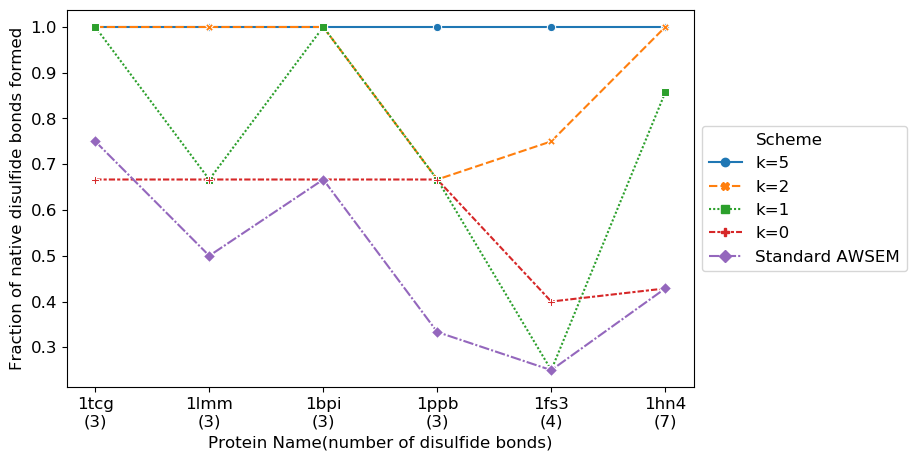

In [22]:
a = selected.groupby(["Protein", "Submode"])["fraction"].max().reset_index()
a["Scheme"] = a["Submode"].apply(lambda x: scheme_dic[x])
# a = a.sort_values(["Scheme"]).reset_index()
a.Scheme = pd.Categorical(a.Scheme, categories=['k=5', 'k=2', 'k=1', 'k=0', 'Standard AWSEM'], ordered=True)
a = a.sort_values(["Scheme"]).reset_index()

# a.Protein = pd.Categorical(a.Protein, categories=['1tcg', '1lmm', '1bpi', '1fs3', '1ppb_H', '1hn4_A'], ordered=True)
a.Protein = pd.Categorical(a.Protein, categories=['1tcg', '1lmm', '1bpi', '1ppb_H', '1fs3', '1hn4_A'], ordered=True)

ax = sns.lineplot("Protein", "fraction", hue="Scheme", style="Scheme", markers=True, data=a, dashes=True)
leg = ax.legend(loc = 'center left', bbox_to_anchor = (1.0, 0.5))
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[0] = '1tcg\n(3)'
labels[1] = '1lmm\n(3)'
labels[2] = '1bpi\n(3)'
labels[3] = '1ppb\n(3)'
labels[4] = '1fs3\n(4)'
labels[5] = '1hn4\n(7)'
ax.set_xticklabels(labels)

plt.xlabel("Protein Name(number of disulfide bonds)")
plt.ylabel("Fraction of native disulfide bonds formed")

plt.savefig("/Users/weilu/Dropbox/openAWSEM/figures/k_cys_fraction_v2.png", dpi=300, bbox_inches='tight')

In [24]:
data["Submode"] = data["Submode"].astype(str)
data["Scheme"] = data["Submode"].apply(lambda x: scheme_dic[x])
selected = data.query("Steps > 2200 and Protein != '1hn4'").sort_values("Q").groupby(["Protein", "Submode"]).tail(1)

selected.Scheme = pd.Categorical(selected.Scheme, categories=['k=5', 'k=2', 'k=1', 'k=0', 'Standard AWSEM'], ordered=True)
selected = selected.sort_values(["Scheme"]).reset_index()

selected.Protein = pd.Categorical(selected.Protein, categories=['1tcg', '1lmm', '1bpi', '1fs3', '1hn4_A', '1ppb_H'], ordered=True)



In [26]:
pd.set_option('display.max_columns', 1000)

In [27]:
selected.query("Protein=='1fs3'")

,index,Steps,Q,Rg,Backbone,Rama,Contact,Fragment,Membrane,ER,TBM_Q,Beta,Pap,Helical,Disulfide,Total,Run,Protein,Submode,Length,Scheme,Unnamed: 0.1,model,level_4,fraction,TP,FN,FP
4,1218408,2436,0.77,14.36,350.26,-544.59,-190.38,-320.47,0.0,0.0,0.0,-69.85,-15.97,0.0,-16.86,-807.87,6,1fs3,333,124,k=5,90977.0,2434.0,0.0,1.000000,4.0,0.0,0.0
10,1170740,2306,0.73,14.30,392.96,-576.44,-190.69,-304.84,0.0,0.0,0.0,-57.03,-19.90,0.0,-4.52,-760.45,7,1fs3,332,124,k=2,83663.0,2304.0,0.0,0.750000,3.0,1.0,0.0
15,1135729,2323,0.62,15.15,378.16,-584.25,-197.35,-284.72,0.0,0.0,0.0,-52.48,-18.25,0.0,-0.99,-759.89,13,1fs3,331,124,k=1,84630.0,2321.0,0.0,0.166667,1.0,3.0,2.0
21,1073161,2305,0.56,15.15,367.80,-596.38,-185.30,-277.99,0.0,0.0,0.0,-63.41,-17.22,0.0,0.00,-772.51,8,1fs3,330,124,k=0,83609.0,2303.0,0.0,0.200000,1.0,3.0,1.0
28,1020552,2238,0.67,14.94,385.31,-569.85,-187.93,-293.72,0.0,0.0,0.0,-52.48,-15.36,0.0,0.00,-734.04,7,1fs3,3300,124,Standard AWSEM,79915.0,2236.0,0.0,0.250000,1.0,3.0,0.0


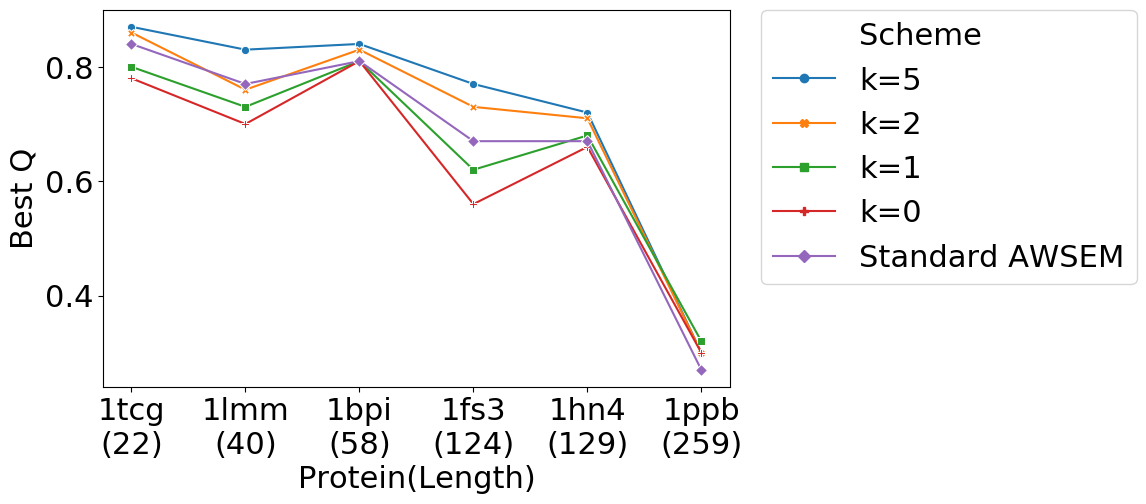

In [222]:
ax = sns.lineplot("Protein", "Q", hue="Scheme", style="Scheme", markers=True, data=selected.sort_values(["Scheme", "Protein"]).reset_index(drop=True), dashes=False)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel("Best Q")
plt.xlabel("Protein(Length)")
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[0] = '1tcg\n(22)'
labels[1] = '1lmm\n(40)'
labels[2] = '1bpi\n(58)'
labels[3] = '1fs3\n(124)'
labels[4] = '1hn4\n(129)'
labels[5] = '1ppb\n(259)'
ax.set_xticklabels(labels)
plt.savefig("/Users/weilu/Dropbox/openAWSEM/figures/k_cys_bestQ_v2.png", dpi=300, bbox_inches='tight')




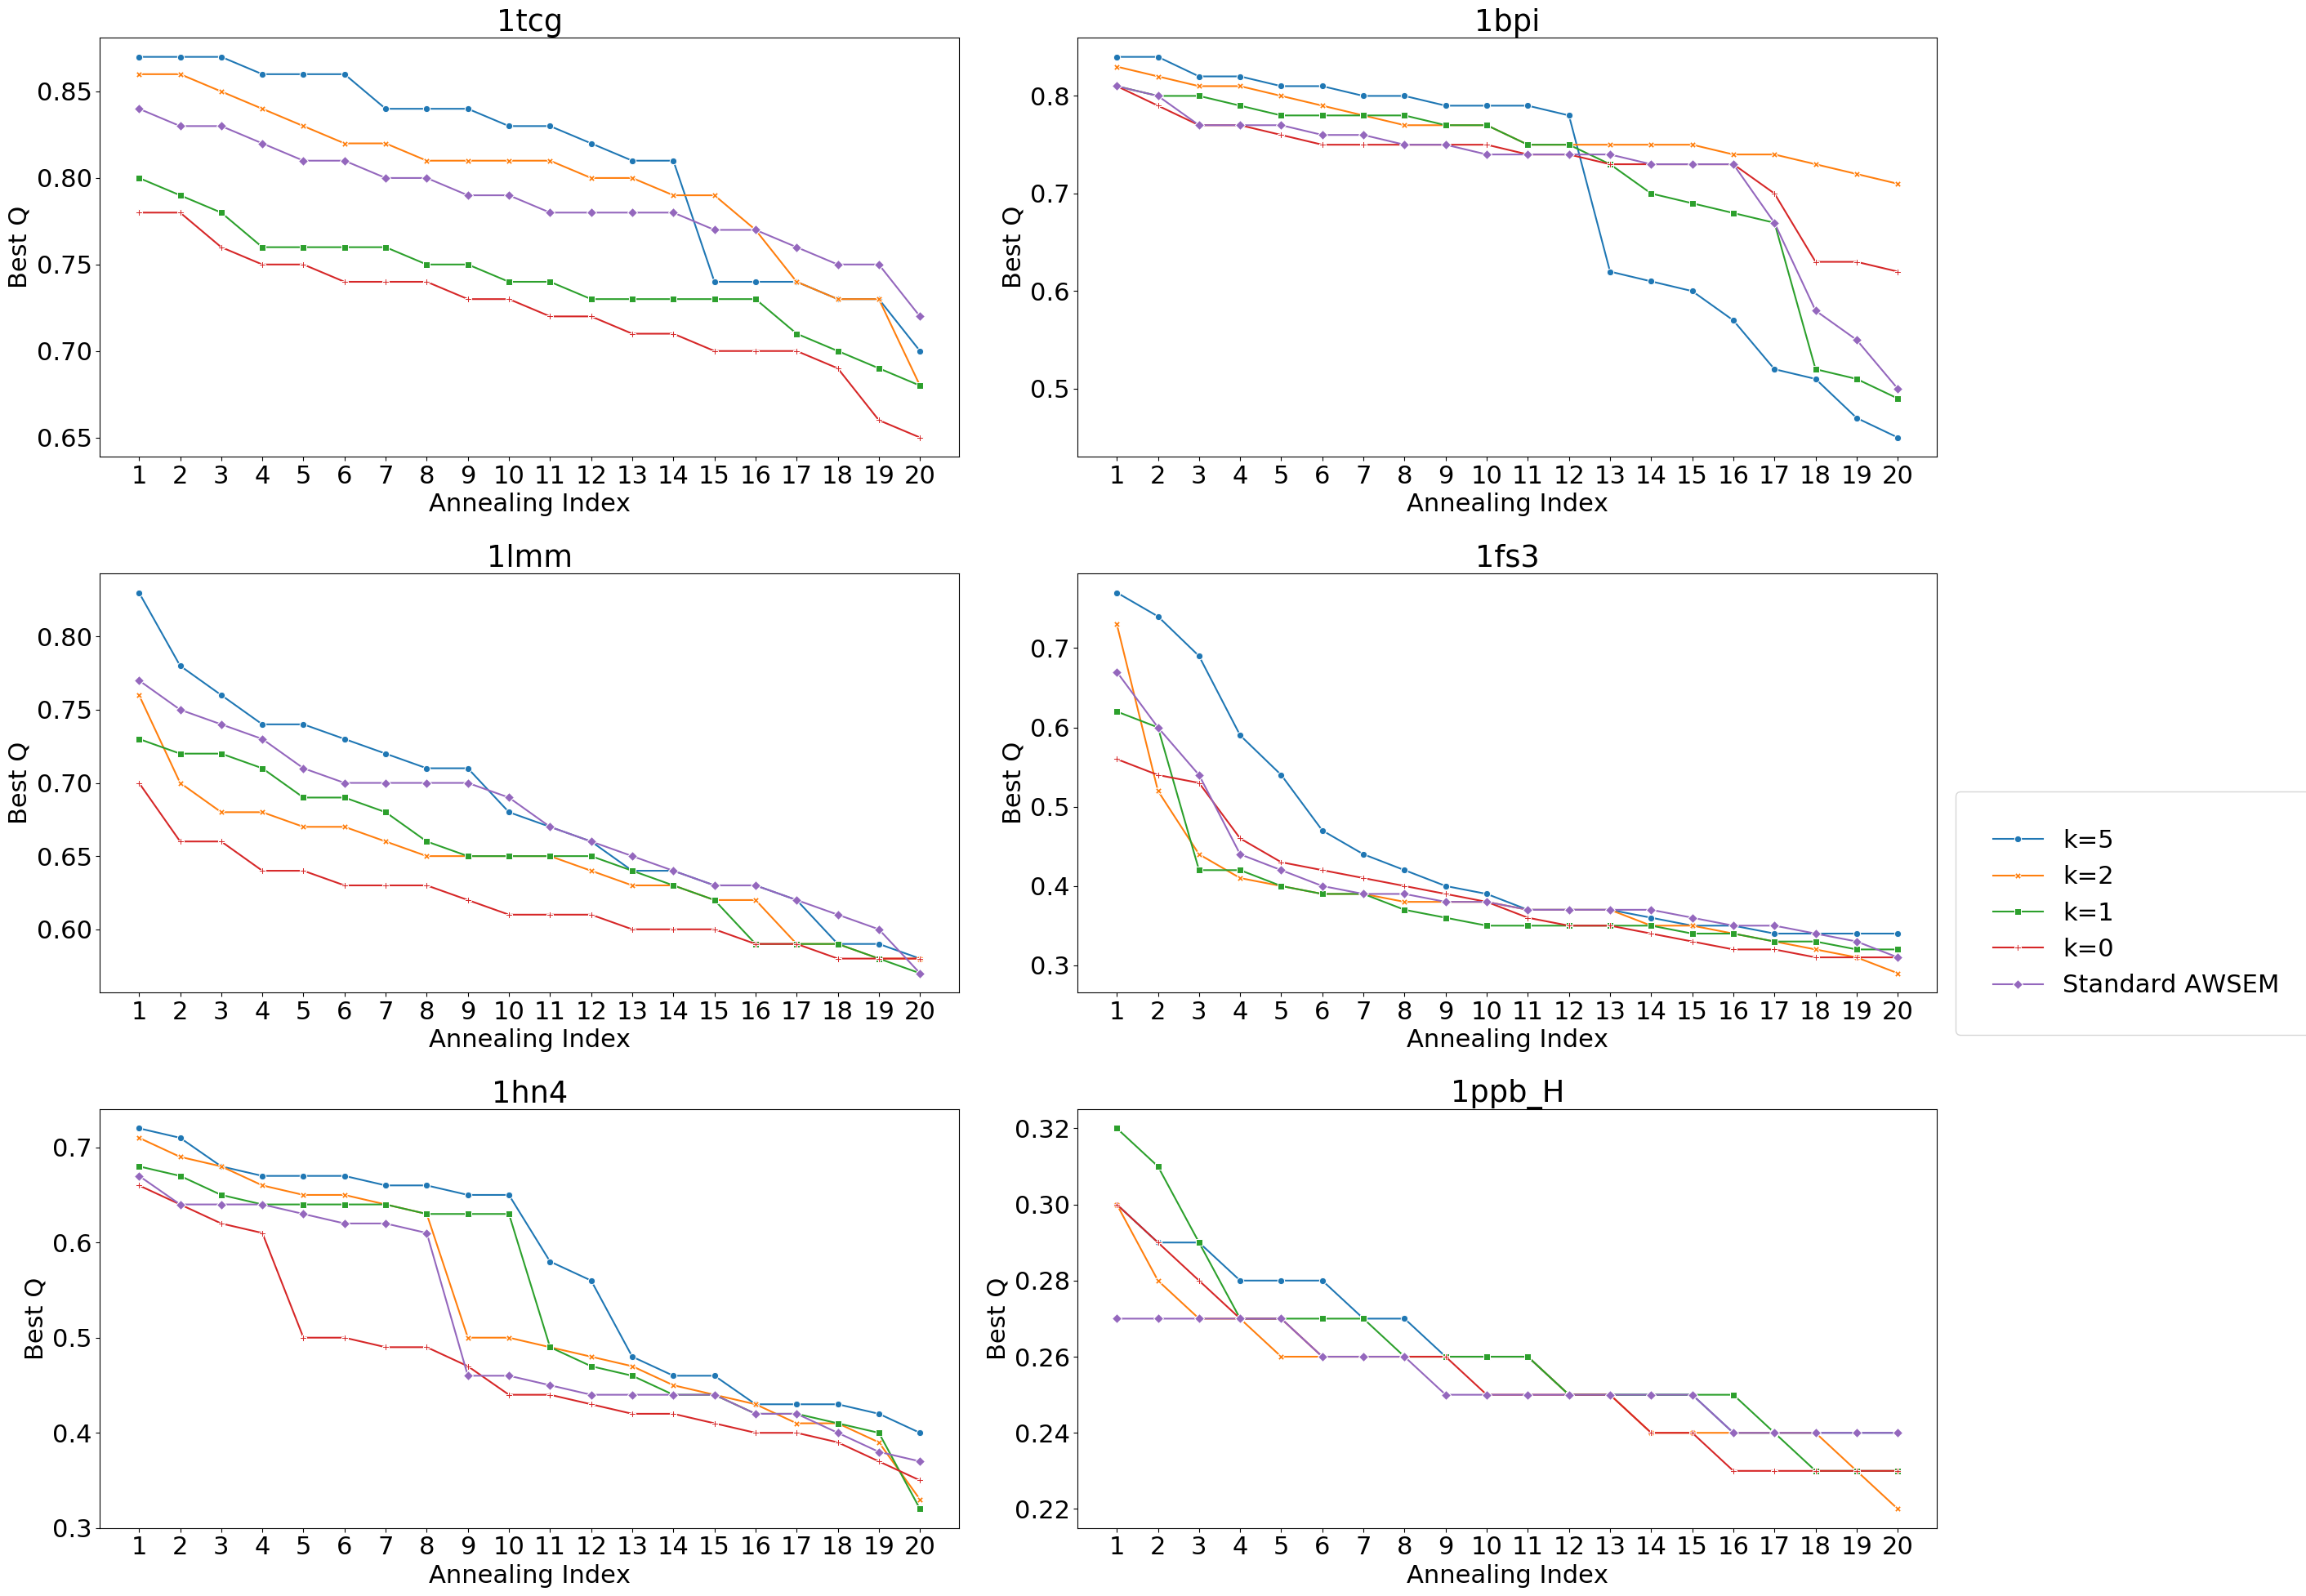

In [21]:

filtered_data = data.query("Steps > 2200")

# filtered_data = filtered_data.query("k_cys != 'original'")
Q_max = filtered_data.sort_values('Q').groupby(["Protein", "Scheme", "Run"]).tail(1).sort_values(["Protein", 'Scheme', "Q"]).reset_index(drop=True)
Q_max["Annealing Index"] = Q_max.groupby(["Protein", "Scheme"])["Q"].rank(method="first", ascending=False).astype(int)
# Q_max.k_cys = pd.Categorical(Q_max.k_cys,  ['k=5', 'k=2', 'k=1', 'k=0', 'Standard AWSEM'], ordered=True)
# Q_max["Scheme"] = Q_max["k_cys"]
Q_max.Scheme = pd.Categorical(Q_max.Scheme, categories=['k=5', 'k=2', 'k=1', 'k=0', 'Standard AWSEM'], ordered=True)
Q_max = Q_max.sort_values(["Scheme"]).reset_index()


fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(1.5*16.18033, 2*10))

protein = '1tcg'
Q_max_one = Q_max.query(f"Protein == '{protein}'")
ax = sns.lineplot("Annealing Index", "Q", hue="Scheme", data=Q_max_one, legend=False,
                  markers=True, style="Scheme", dashes=False, ax=axes[0][0])
_ = ax.set_xticks(np.arange(1, 21, 1))
ax.set_ylabel("Best Q")
ax.set_title(f"{protein}")

protein = '1bpi'
Q_max_one = Q_max.query(f"Protein == '{protein}'")
ax = sns.lineplot("Annealing Index", "Q", hue="Scheme", data=Q_max_one, legend=False,
                  markers=True, style="Scheme", dashes=False, ax=axes[0][1])
_ = ax.set_xticks(np.arange(1, 21, 1))
ax.set_ylabel("Best Q")
ax.set_title(f"{protein}")

protein = '1lmm'
Q_max_one = Q_max.query(f"Protein == '{protein}'")
ax = sns.lineplot("Annealing Index", "Q", hue="Scheme", data=Q_max_one, legend=False,
                  markers=True, style="Scheme", dashes=False, ax=axes[1][0])
_ = ax.set_xticks(np.arange(1, 21, 1))
ax.set_ylabel("Best Q")
ax.set_title(f"{protein}")



protein = '1fs3'
Q_max_one = Q_max.query(f"Protein == '{protein}'")
ax = sns.lineplot("Annealing Index", "Q", hue="Scheme", data=Q_max_one, legend=False,
                  markers=True, style="Scheme", dashes=False, ax=axes[1][1])
_ = ax.set_xticks(np.arange(1, 21, 1))
ax.set_ylabel("Best Q")
ax.set_title(f"{protein}")

protein = '1hn4_A'
Q_max_one = Q_max.query(f"Protein == '{protein}'")
ax = sns.lineplot("Annealing Index", "Q", hue="Scheme", data=Q_max_one, legend=False,
                  markers=True, style="Scheme", dashes=False, ax=axes[2][0])
_ = ax.set_xticks(np.arange(1, 21, 1))
ax.set_ylabel("Best Q")
ax.set_title(f"1hn4")


protein = '1ppb_H'
Q_max_one = Q_max.query(f"Protein == '{protein}'")
ax = sns.lineplot("Annealing Index", "Q", hue="Scheme", data=Q_max_one, legend=False,
                  markers=True, style="Scheme", dashes=False, ax=axes[2][1])
_ = ax.set_xticks(np.arange(1, 21, 1))
ax.set_ylabel("Best Q")
ax.set_title(f"{protein}")


# fig.legend((['k_0', 'k_1', 'k_2', 'k_5', 'original']), loc='center right', bbox_to_anchor=(0.7, 0.15))
fig.legend((['k=5', 'k=2', 'k=1', 'k=0', 'Standard AWSEM']), bbox_to_anchor=(0.98, 0.5), loc=2, borderpad=1.5)
# fig.legend((['k_0', 'k_1', 'k_2', 'k_5', 'original']), loc="lower left", ncol=5)
# fig.legend((['k_0', 'k_1', 'k_2', 'k_5', 'original']), loc='lower center')
# axes[-1, -1].axis('off')

plt.tight_layout()
plt.savefig(f"{figureFolder}/seperate_run_best_include_1ppb_v2.png", dpi=300, bbox_inches='tight')


In [6]:
data_cys = pd.read_csv("/Users/weilu/Research/data/openMM/cys_all_run2_single_timeStep2_lesser_frag_06-17.csv", index_col=0)

/Users/weilu/anaconda/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [7]:
native_pair = ['65_72', '40_95', '58_110', '26_84']
# group they by pair
t = data_cys.query("Protein=='1fs3' and Submode=='3300'").reset_index(drop=True)
t["pair"] = (1 + t["i"]).astype(str) + "_" + (1 + t["j"]).astype(str)

# tt = t.query("Run==5").reset_index(drop=True)
tt = t
pair_list = tt["pair"].unique().tolist()

pair_list = sorted(pair_list)
n_pair = len(pair_list)

pair_dict = {}
for i, pair in enumerate(pair_list):
    pair_dict[pair] = i

pair_timeline = np.zeros((n_pair, 2500))

for i, line in tt.iterrows():
    frame = line["model"]
    pair = line["pair"]
    if pair in native_pair:
        pair_timeline[pair_dict[pair]][frame] += 1/20
    else:
        pair_timeline[pair_dict[pair]][frame] -= 1/20

In [8]:
pair_timeline_3300 = pair_timeline

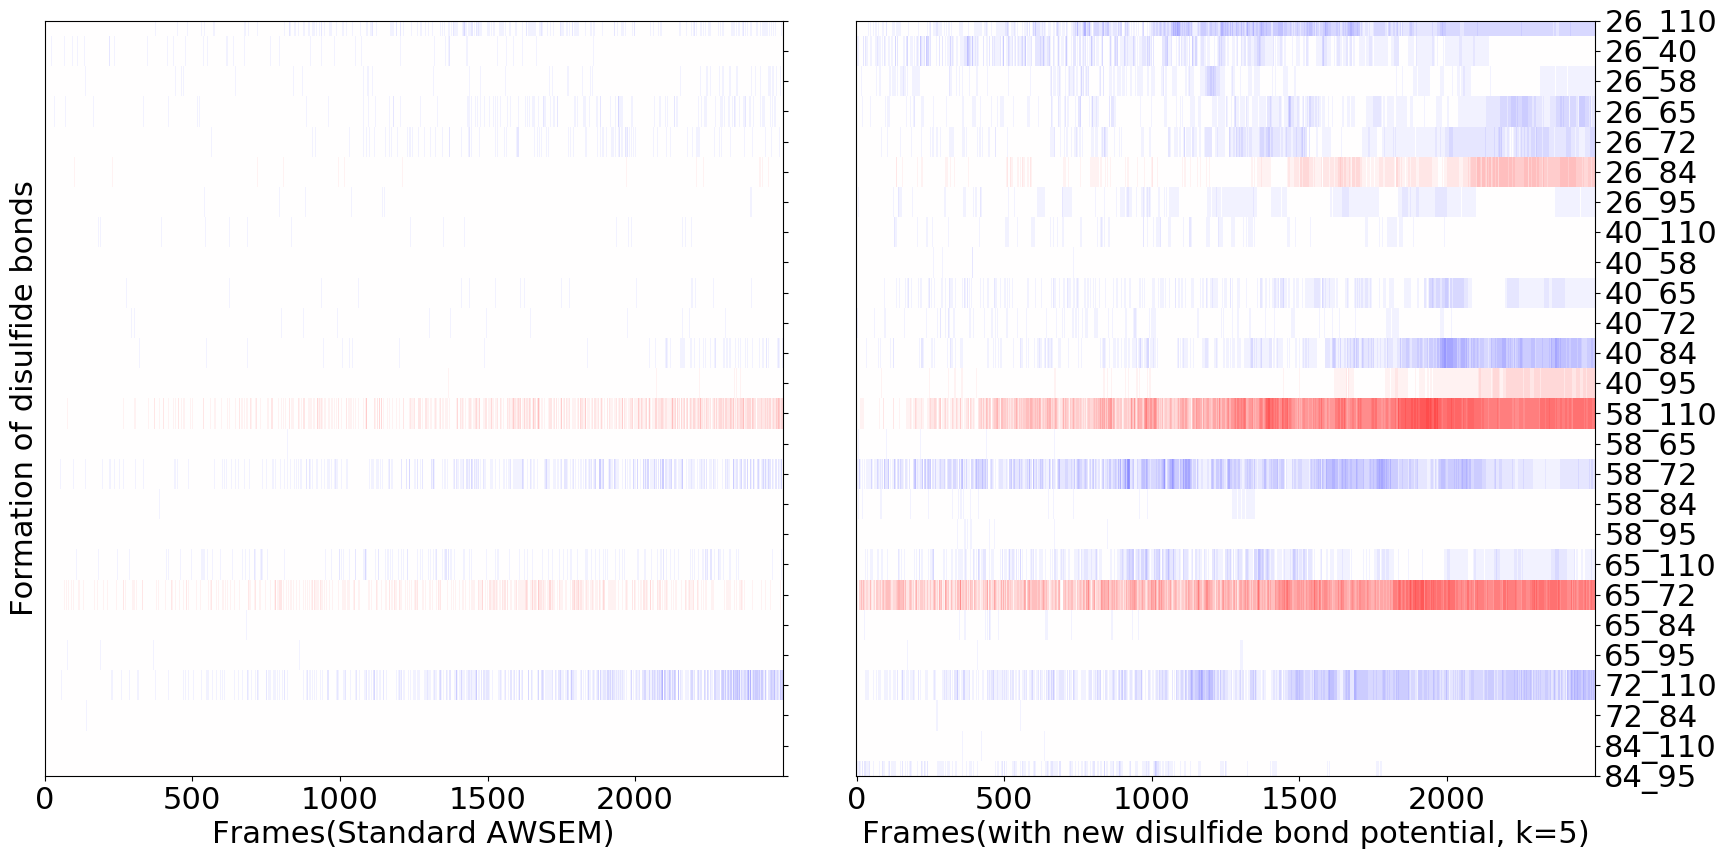

In [37]:
f = plt.figure(figsize = (20,10))
ax = f.add_subplot(121)
ax.yaxis.tick_right()
plt.imshow(pair_timeline_3300, aspect='auto', cmap="bwr", vmin=-1, vmax=1)
_ = plt.yticks(ticks=range(n_pair), labels="")
# ax.set_yticklabels([])
#  yaxis.tick_right()
plt.xlabel("Frames(Standard AWSEM)")
plt.ylabel("Formation of disulfide bonds")

ax = f.add_subplot(122)
ax.yaxis.tick_right()
plt.imshow(pair_timeline_333, aspect='auto', cmap="bwr", vmin=-1, vmax=1)
_ = plt.yticks(ticks=range(n_pair), labels=pair_list)
plt.xlabel("Frames(with new disulfide bond potential, k=5)")
f.subplots_adjust(wspace=0.1, hspace=0)
# plt.tight_layout
plt.savefig(f"{figureFolder}/1fs3_combined_average_trajectory.png", dpi=300, bbox_inches='tight')

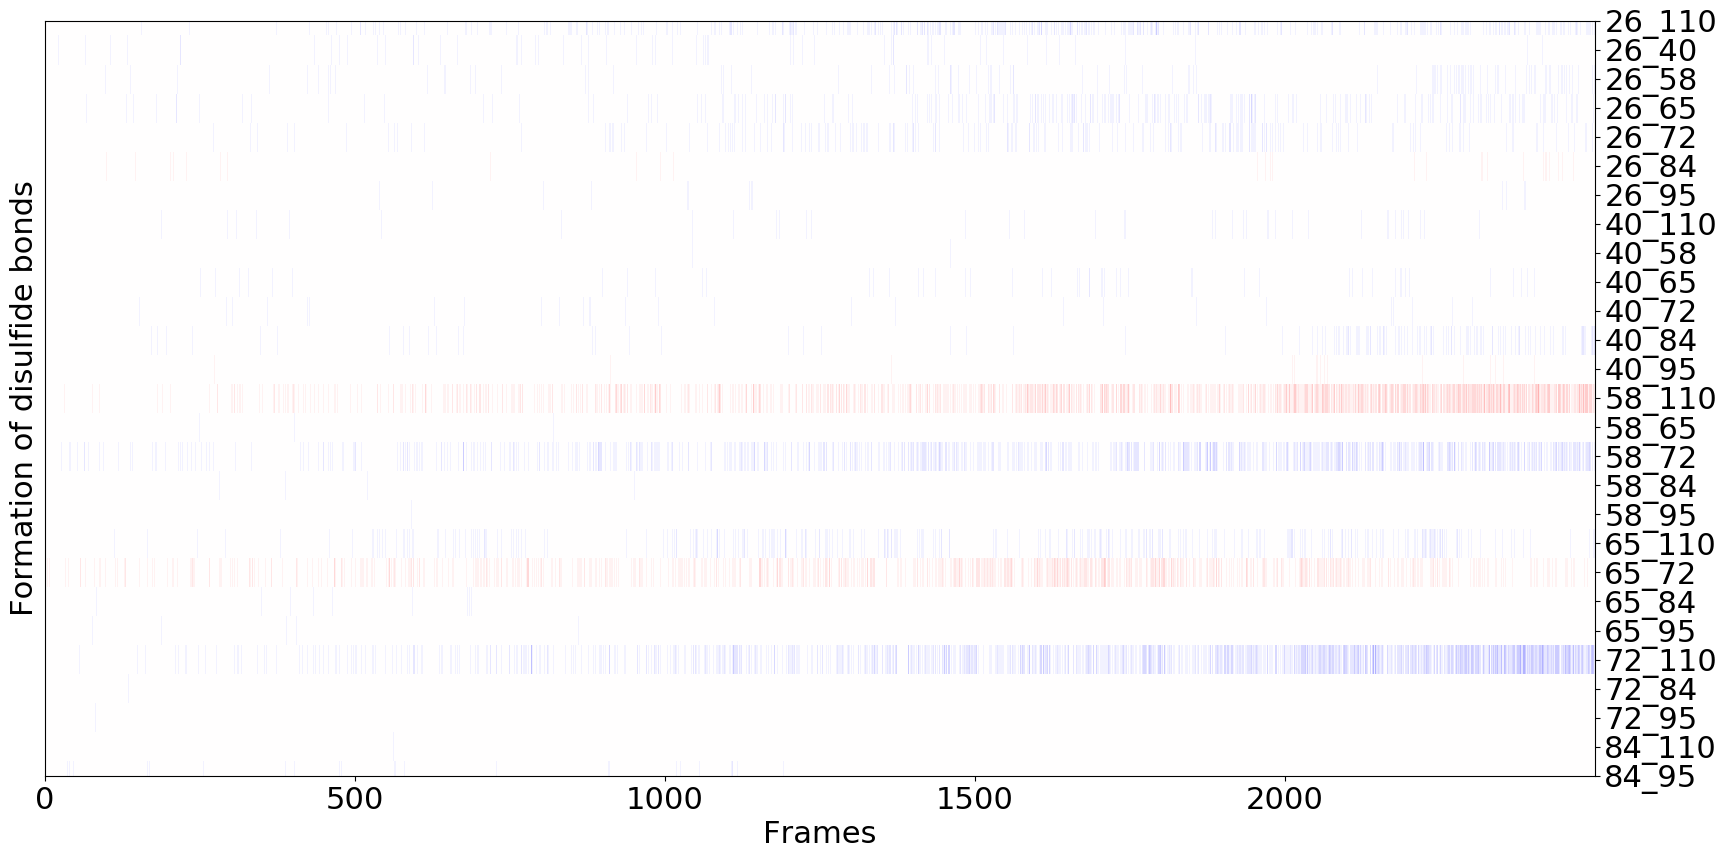

In [9]:
f = plt.figure(figsize = (20,10))
ax = f.add_subplot(111)
ax.yaxis.tick_right()
plt.imshow(pair_timeline, aspect='auto', cmap="bwr", vmin=-1, vmax=1)
_ = plt.yticks(ticks=range(n_pair), labels=pair_list)
#  yaxis.tick_right()
plt.xlabel("Frames")
plt.ylabel("Formation of disulfide bonds")
plt.savefig(f"{figureFolder}/1fs3_mode3300_average_trajectory.png", dpi=300, bbox_inches='tight')

In [18]:
native_pair = ['65_72', '40_95', '58_110', '26_84']
# group they by pair
t = data_cys.query("Protein=='1fs3' and Submode=='3300'").reset_index(drop=True)
t["pair"] = (1 + t["i"]).astype(str) + "_" + (1 + t["j"]).astype(str)

tt = t.query("Run==7").reset_index(drop=True)
# tt = t
pair_list = tt["pair"].unique().tolist()

pair_list = sorted(pair_list)
n_pair = len(pair_list)

pair_dict = {}
for i, pair in enumerate(pair_list):
    pair_dict[pair] = i

pair_timeline = np.zeros((n_pair, 2500))

for i, line in tt.iterrows():
    frame = line["model"]
    pair = line["pair"]
    if pair in native_pair:
        pair_timeline[pair_dict[pair]][frame] += 1
    else:
        pair_timeline[pair_dict[pair]][frame] -= 1

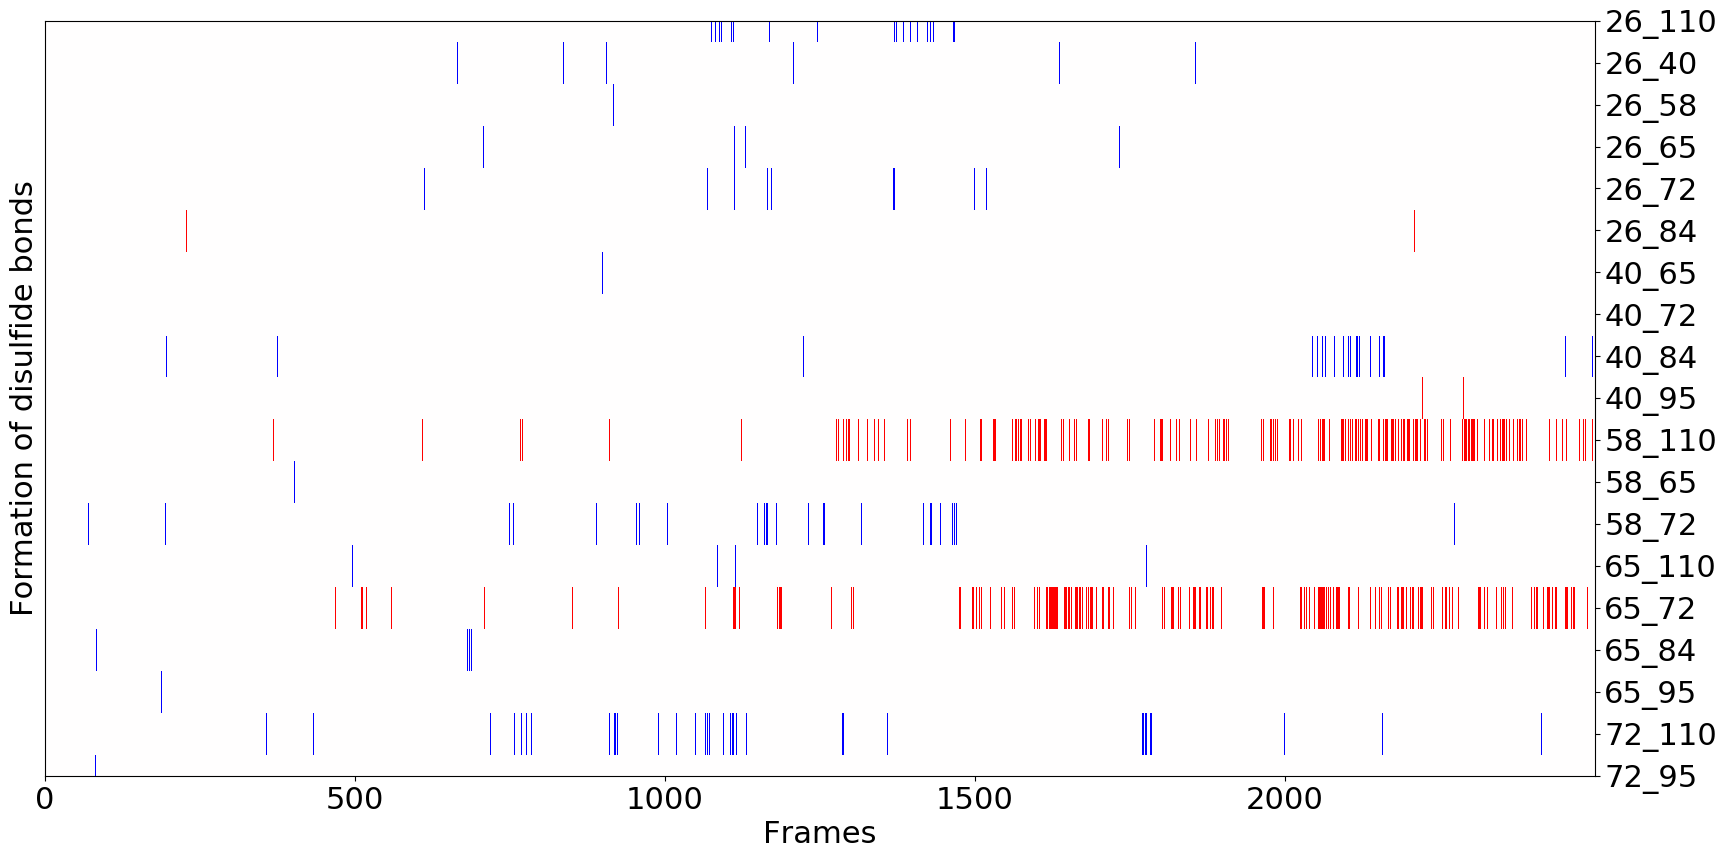

In [19]:
f = plt.figure(figsize = (20,10))
ax = f.add_subplot(111)
ax.yaxis.tick_right()
plt.imshow(pair_timeline, aspect='auto', cmap="bwr", vmin=-1, vmax=1)
_ = plt.yticks(ticks=range(n_pair), labels=pair_list)
#  yaxis.tick_right()
plt.xlabel("Frames")
plt.ylabel("Formation of disulfide bonds")
plt.savefig(f"{figureFolder}/1fs3_mode3300_run_7_trajectory.png", dpi=300, bbox_inches='tight')

In [16]:
native_pair = ['65_72', '40_95', '58_110', '26_84']
# group they by pair
t = data_cys.query("Protein=='1fs3' and Submode=='333'").reset_index(drop=True)
t["pair"] = (1 + t["i"]).astype(str) + "_" + (1 + t["j"]).astype(str)

# tt = t.query("Run==5").reset_index(drop=True)
tt = t
pair_list = tt["pair"].unique().tolist()

pair_list = sorted(pair_list)
n_pair = len(pair_list)

pair_dict = {}
for i, pair in enumerate(pair_list):
    pair_dict[pair] = i

pair_timeline = np.zeros((n_pair, 2500))

for i, line in tt.iterrows():
    frame = line["model"]
    pair = line["pair"]
    if pair in native_pair:
        pair_timeline[pair_dict[pair]][frame] += 1/20
    else:
        pair_timeline[pair_dict[pair]][frame] -= 1/20

In [17]:
pair_timeline_333 = pair_timeline

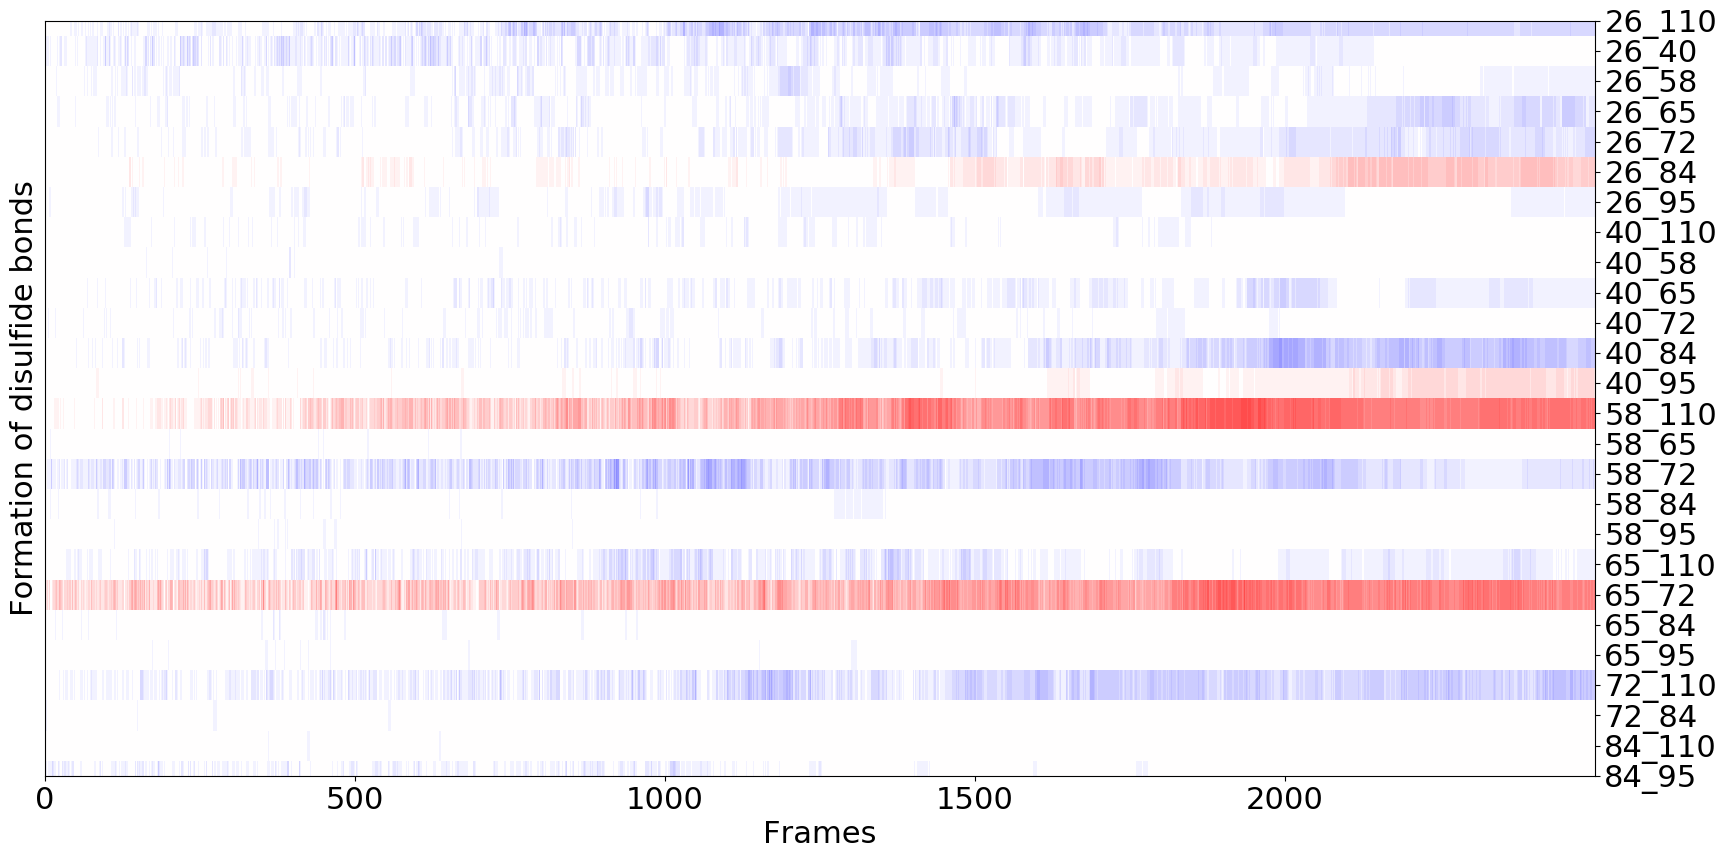

In [21]:
f = plt.figure(figsize = (20,10))
ax = f.add_subplot(111)
ax.yaxis.tick_right()
plt.imshow(pair_timeline, aspect='auto', cmap="bwr", vmin=-1, vmax=1)
_ = plt.yticks(ticks=range(n_pair), labels=pair_list)
#  yaxis.tick_right()
plt.xlabel("Frames")
plt.ylabel("Formation of disulfide bonds")
plt.savefig(f"{figureFolder}/1fs3_mode333_average_trajectory.png", dpi=300, bbox_inches='tight')

In [24]:
native_pair = ['65_72', '40_95', '58_110', '26_84']
# group they by pair
t = data_cys.query("Protein=='1fs3' and Submode=='333'").reset_index(drop=True)
t["pair"] = (1 + t["i"]).astype(str) + "_" + (1 + t["j"]).astype(str)

tt = t.query("Run==6").reset_index(drop=True)
# tt = t
pair_list = tt["pair"].unique().tolist()

pair_list = sorted(pair_list)
n_pair = len(pair_list)

pair_dict = {}
for i, pair in enumerate(pair_list):
    pair_dict[pair] = i

pair_timeline = np.zeros((n_pair, 2500))

for i, line in tt.iterrows():
    frame = line["model"]
    pair = line["pair"]
    if pair in native_pair:
        pair_timeline[pair_dict[pair]][frame] += 1
    else:
        pair_timeline[pair_dict[pair]][frame] -= 1

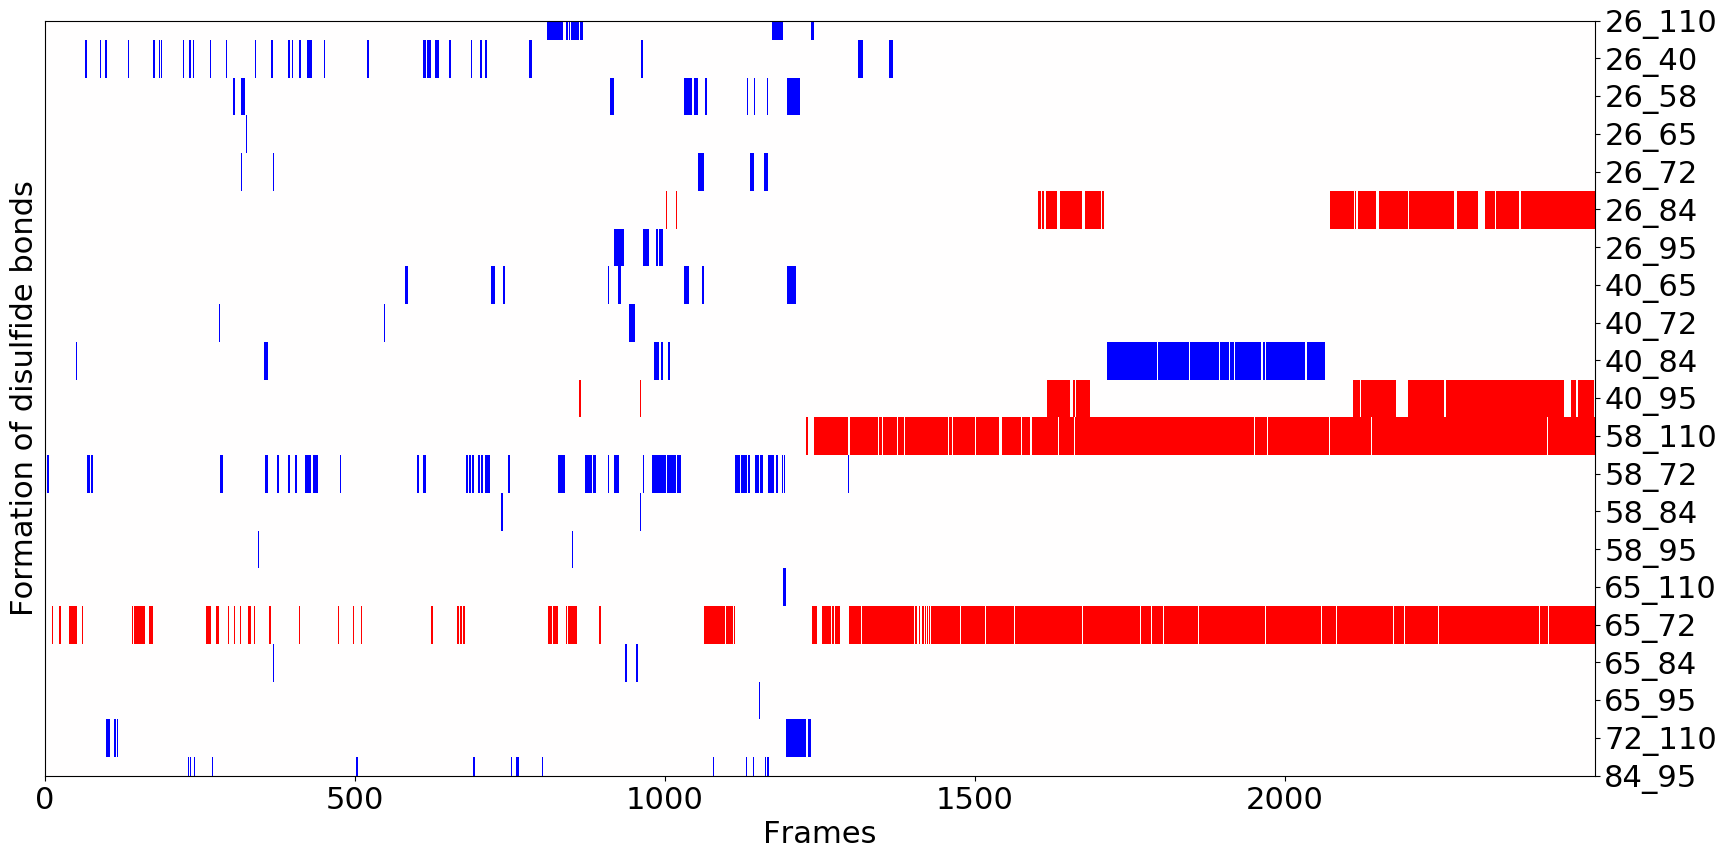

In [25]:
f = plt.figure(figsize = (20,10))
ax = f.add_subplot(111)
ax.yaxis.tick_right()
plt.imshow(pair_timeline, aspect='auto', cmap="bwr", vmin=-1, vmax=1)
_ = plt.yticks(ticks=range(n_pair), labels=pair_list)
#  yaxis.tick_right()
plt.xlabel("Frames")
plt.ylabel("Formation of disulfide bonds")
plt.savefig(f"{figureFolder}/1fs3_mode333_run_6_trajectory.png", dpi=300, bbox_inches='tight')

In [42]:
native_pair = ['65_72', '40_95', '58_110', '26_84']
# group they by pair
t = data_cys.query("Protein=='1fs3' and Submode=='333'").reset_index(drop=True)
t["pair"] = (1 + t["i"]).astype(str) + "_" + (1 + t["j"]).astype(str)

# tt = t.query("Run==5").reset_index(drop=True)
tt = t
pair_list = tt["pair"].unique().tolist()

pair_list = sorted(pair_list)
n_pair = len(pair_list)

pair_dict = {}
for i, pair in enumerate(pair_list):
    pair_dict[pair] = i

pair_timeline = np.zeros((n_pair, 2500))

for i, line in tt.iterrows():
    frame = line["model"]
    pair = line["pair"]
    if pair in native_pair:
        pair_timeline[pair_dict[pair]][frame] += 1/20
    else:
        pair_timeline[pair_dict[pair]][frame] += 1/20

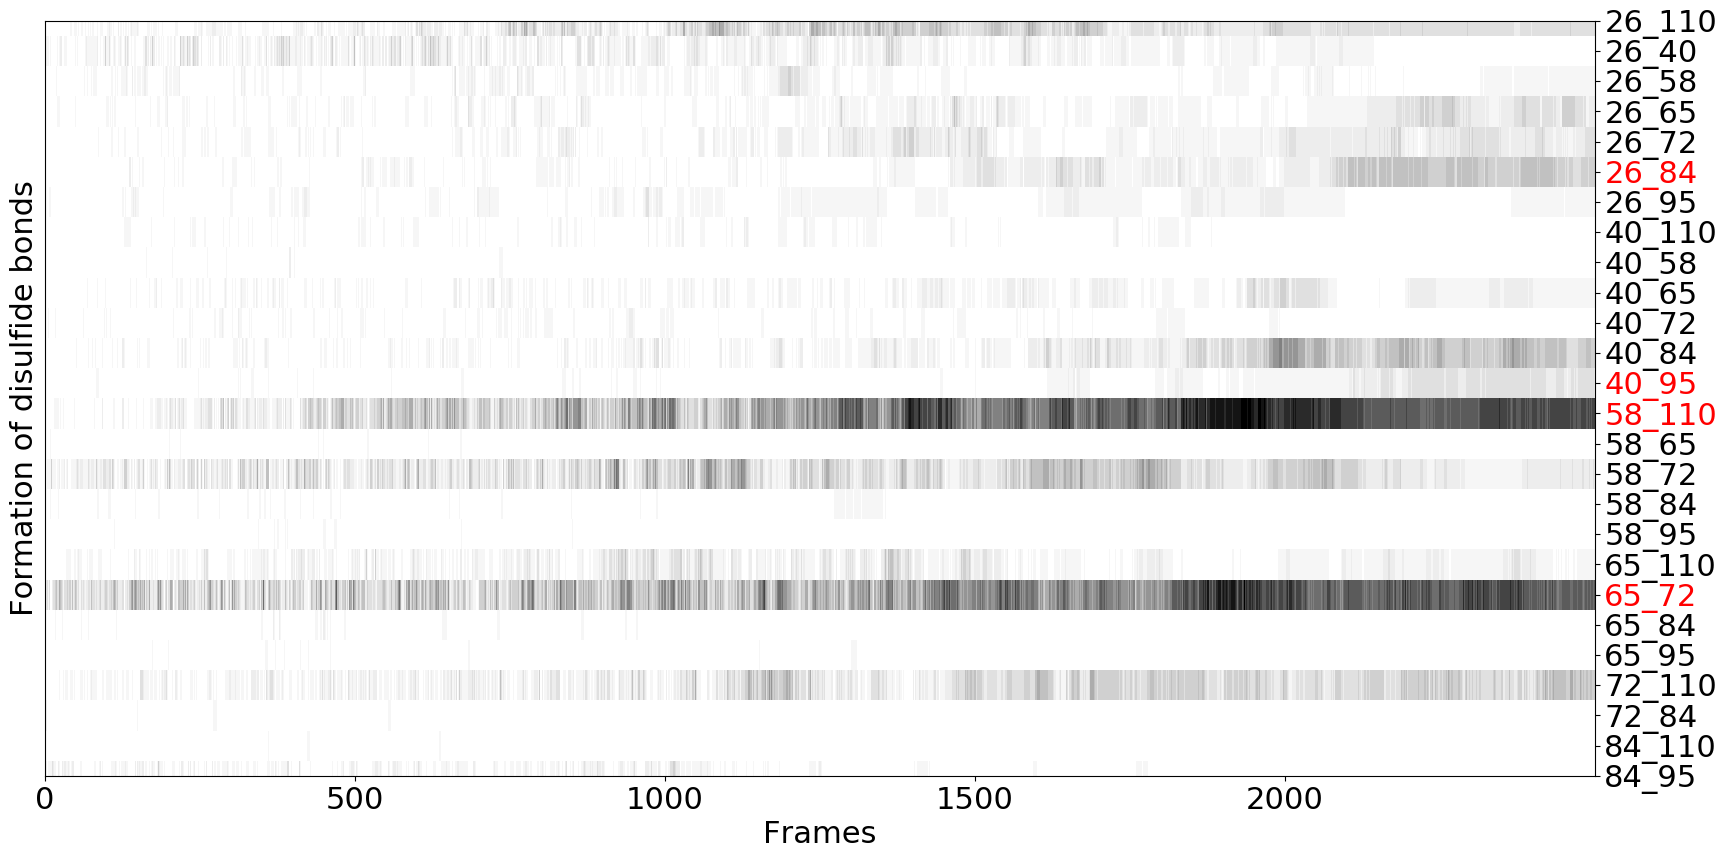

In [54]:
f = plt.figure(figsize = (20,10))
ax = f.add_subplot(111)
ax.yaxis.tick_right()
plt.imshow(pair_timeline, aspect='auto', cmap="Greys")
_ = plt.yticks(ticks=range(n_pair), labels=pair_list)
#  yaxis.tick_right()
plt.xlabel("Frames")
plt.ylabel("Formation of disulfide bonds")

for ytick, pair in zip(ax.get_yticklabels(), pair_list):
    if pair in native_pair:
        ytick.set_color("red")
    else:
        ytick.set_color("black")
# plt.colorbar()
# plt.savefig(f"{figureFolder}/1fs3_run3_mode_333_trajectory.png", dpi=300, bbox_inches='tight')

In [65]:
native_pair = ['65_72', '40_95', '58_110', '26_84']
# group they by pair
t = data_cys.query("Protein=='1fs3' and Submode=='333'").reset_index(drop=True)
t["pair"] = (1 + t["i"]).astype(str) + "_" + (1 + t["j"]).astype(str)

tt = t.query("Run==6").reset_index(drop=True)
# tt = t
pair_list = tt["pair"].unique().tolist()

pair_list = sorted(pair_list)
n_pair = len(pair_list)

pair_dict = {}
for i, pair in enumerate(pair_list):
    pair_dict[pair] = i

pair_timeline = np.zeros((n_pair, 2500))

for i, line in tt.iterrows():
    frame = line["model"]
    pair = line["pair"]
    if pair in native_pair:
        pair_timeline[pair_dict[pair]][frame] = 1 
    else:
        pair_timeline[pair_dict[pair]][frame] = 2

Text(0, 0.5, 'Formation of disulfide bonds')

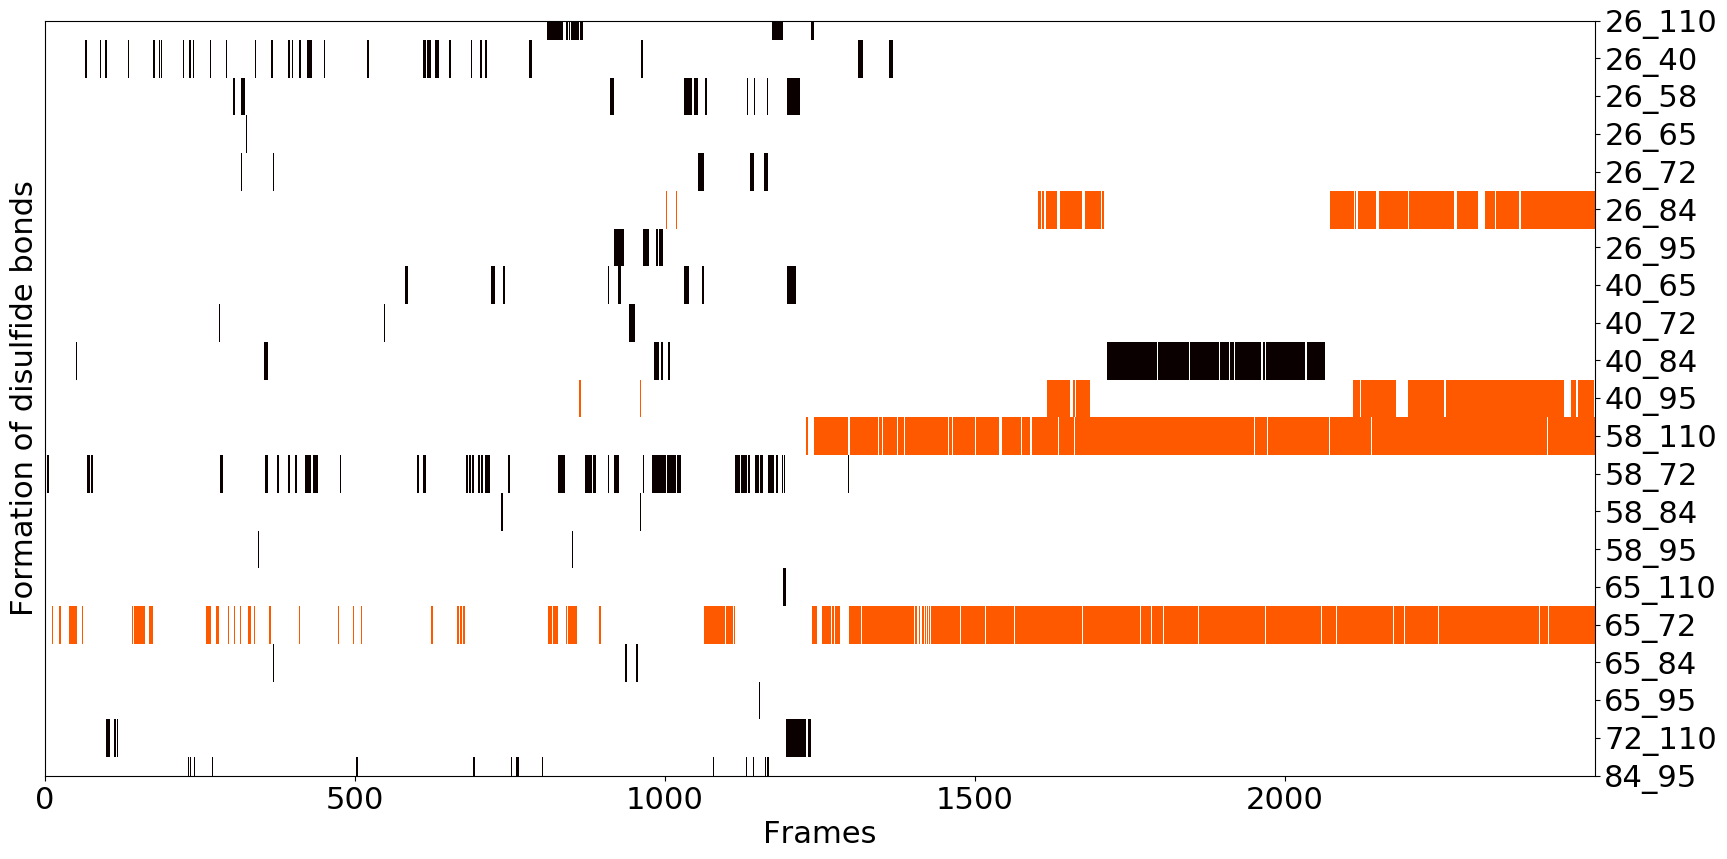

In [66]:
f = plt.figure(figsize = (20,10))
ax = f.add_subplot(111)
ax.yaxis.tick_right()
plt.imshow(pair_timeline, aspect='auto', cmap="hot_r")
_ = plt.yticks(ticks=range(n_pair), labels=pair_list)
#  yaxis.tick_right()
plt.xlabel("Frames")
plt.ylabel("Formation of disulfide bonds")
# plt.savefig(f"{figureFolder}/1fs3_run3_mode_33_trajectory.png", dpi=300, bbox_inches='tight')

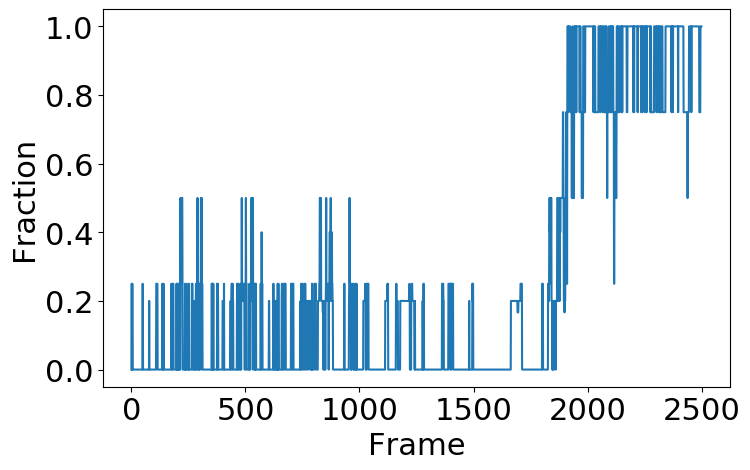

In [50]:
a = pd.DataFrame(range(1, 2501), columns=["Steps"])
t = d_cys.query("Run==3 and Protein=='1fs3' and Submode=='333'").reset_index(drop=True)
t["Steps"] = t["model"] + 1

b = a.merge(t,how="left").fillna(0)
plt.plot(b["fraction"])
plt.xlabel("Frame")
plt.ylabel("Fraction")
plt.savefig("/Users/weilu/Dropbox/openAWSEM/figures/fraction_trajectory_run3_1fs3_333.png", dpi=300, bbox_inches='tight')




Text(0, 0.5, 'Formation of disulfide bonds')

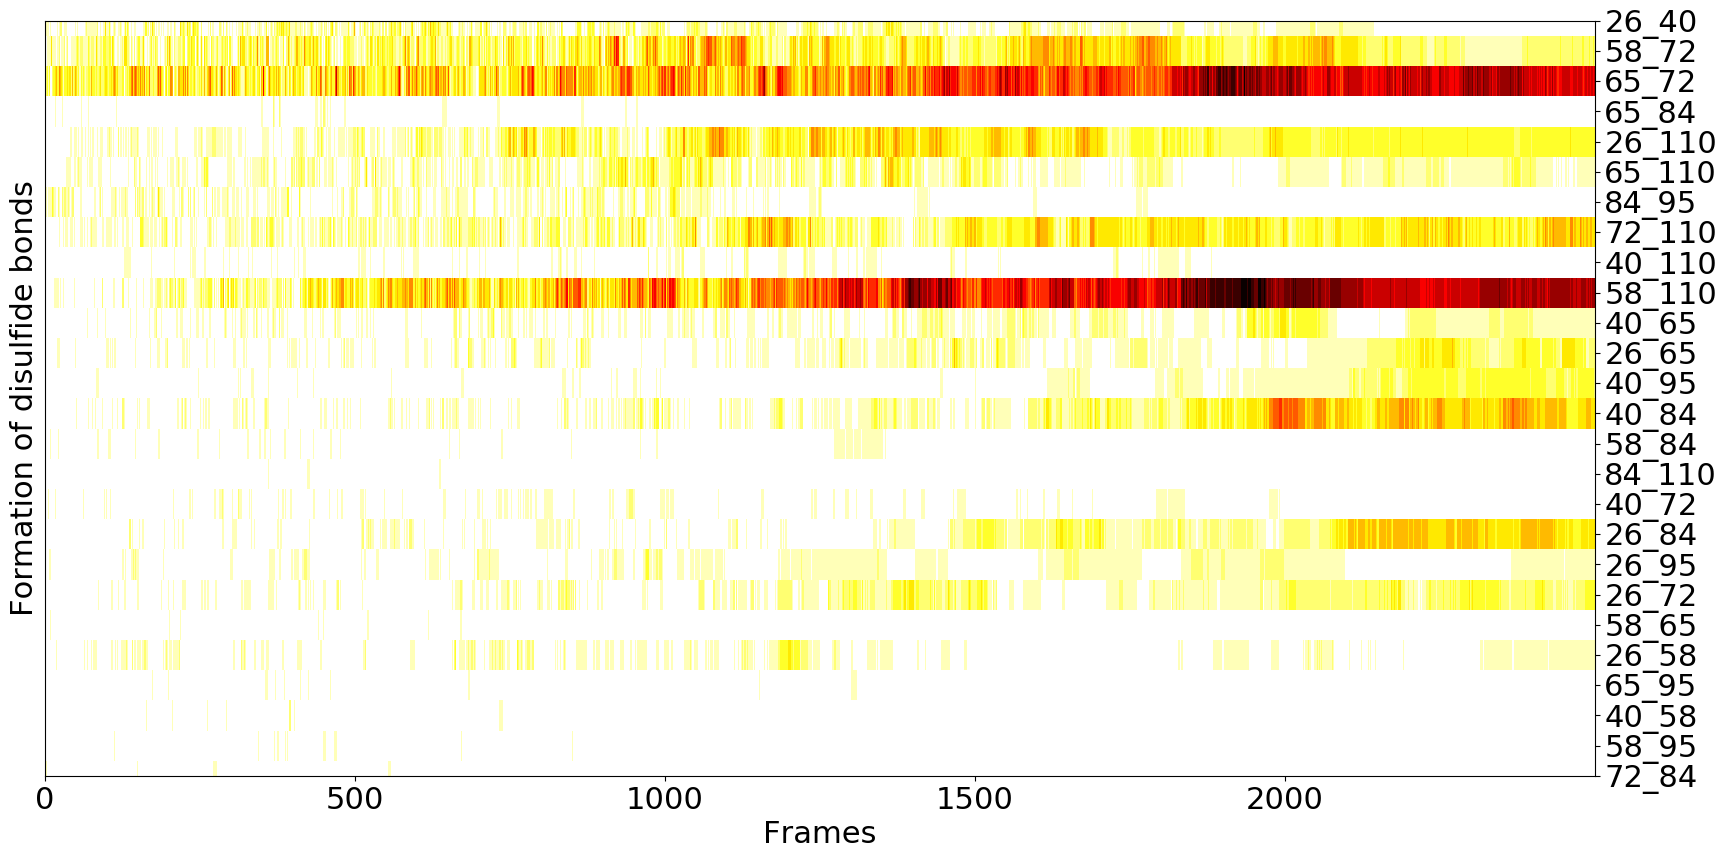

In [63]:
f = plt.figure(figsize = (20,10))
ax = f.add_subplot(111)
ax.yaxis.tick_right()
plt.imshow(pair_timeline, aspect='auto', cmap="hot_r")
_ = plt.yticks(ticks=range(n_pair), labels=pair_list)
#  yaxis.tick_right()
plt.xlabel("Frames")
plt.ylabel("Formation of disulfide bonds")
# plt.colorbar()
# plt.savefig(f"{figureFolder}/1fs3_run3_mode_33_trajectory.png", dpi=300, bbox_inches='tight')

Text(0, 0.5, 'Formation of disulfide bonds')

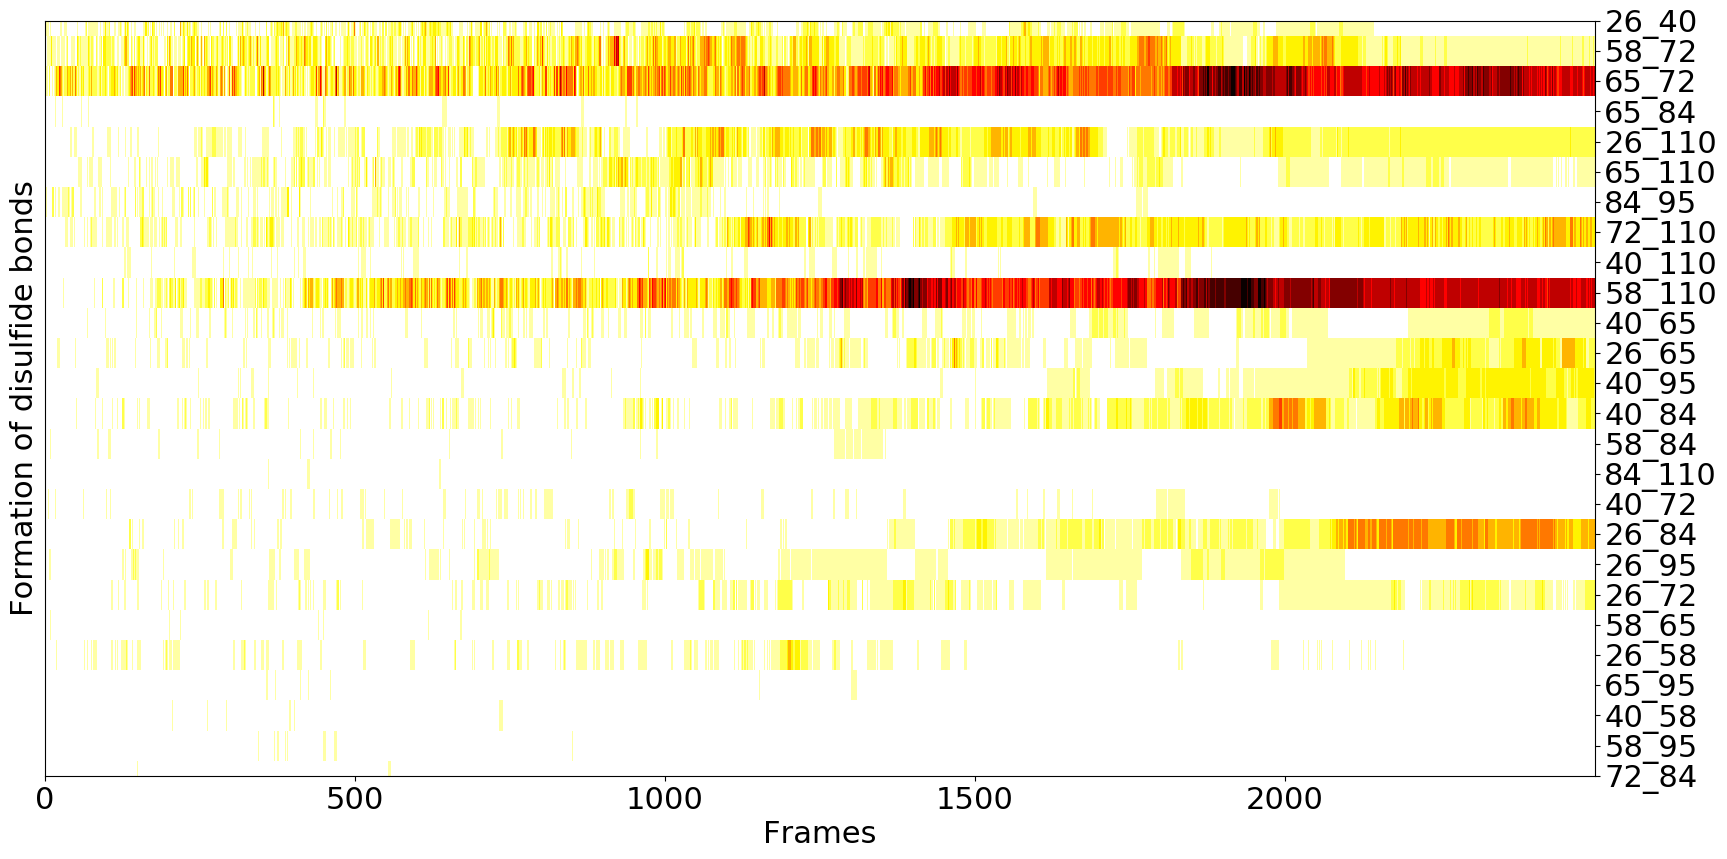

In [51]:
f = plt.figure(figsize = (20,10))
ax = f.add_subplot(111)
ax.yaxis.tick_right()
plt.imshow(pair_timeline, aspect='auto', cmap="hot_r")
_ = plt.yticks(ticks=range(n_pair), labels=pair_list)
#  yaxis.tick_right()
plt.xlabel("Frames")
plt.ylabel("Formation of disulfide bonds")
# plt.colorbar()
# plt.savefig(f"{figureFolder}/1fs3_run3_mode_33_trajectory.png", dpi=300, bbox_inches='tight')

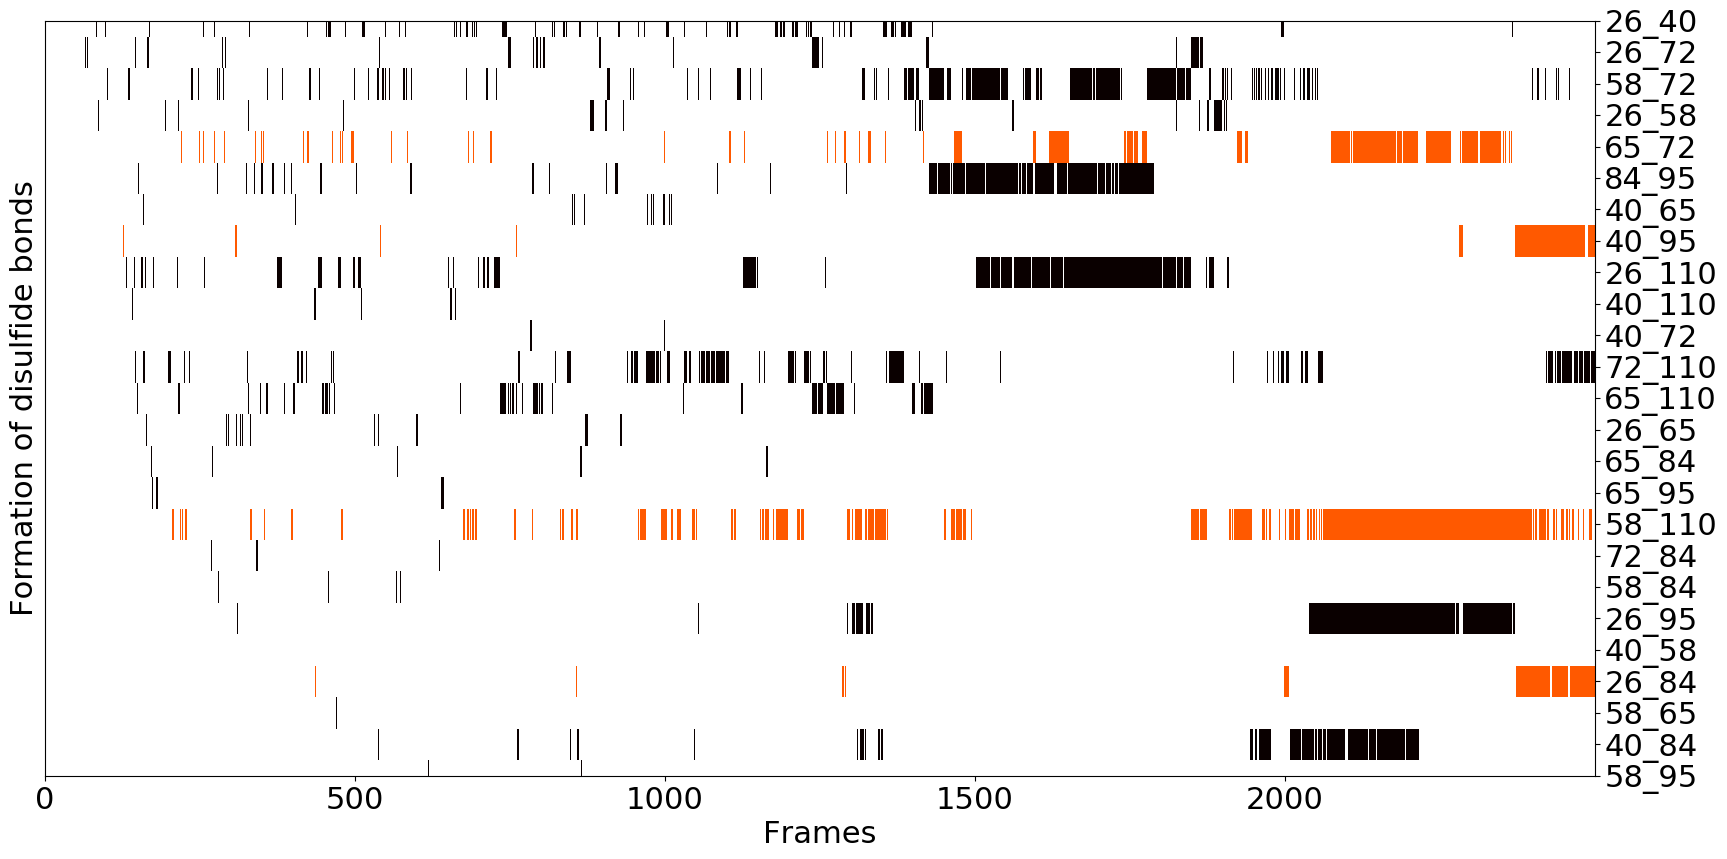

In [477]:
f = plt.figure(figsize = (20,10))
ax = f.add_subplot(111)
ax.yaxis.tick_right()
plt.imshow(pair_timeline, aspect='auto', cmap="hot_r")
_ = plt.yticks(ticks=range(n_pair), labels=pair_list)
#  yaxis.tick_right()
plt.xlabel("Frames")
plt.ylabel("Formation of disulfide bonds")
plt.savefig(f"{figureFolder}/1fs3_run3_mode_33_trajectory.png", dpi=300, bbox_inches='tight')

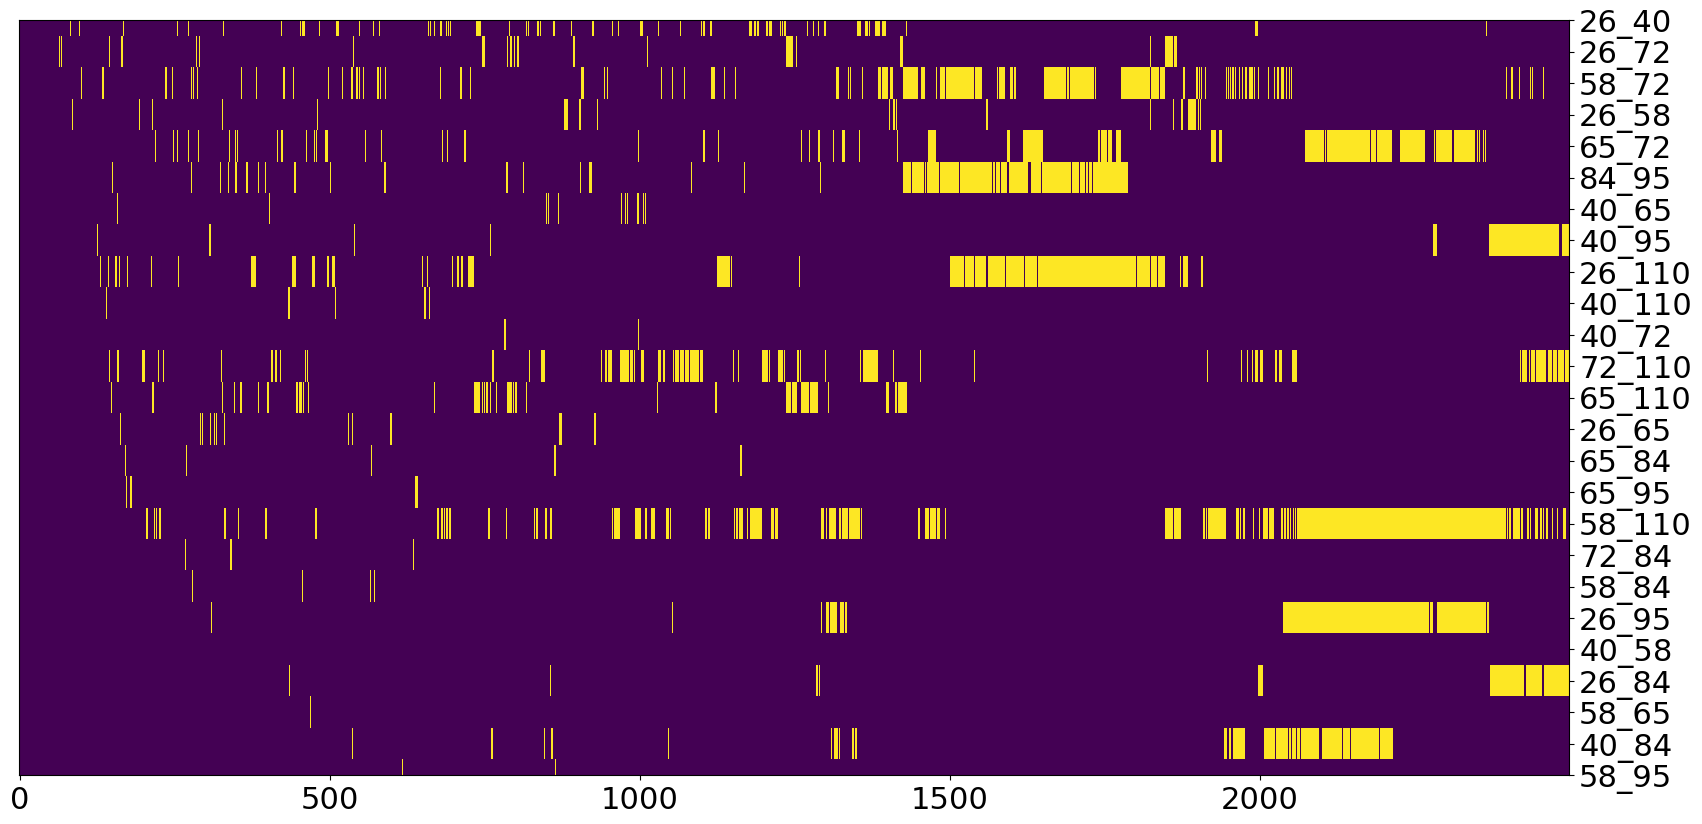

In [455]:
f = plt.figure(figsize = (20,10))
ax = f.add_subplot(111)
ax.yaxis.tick_right()
plt.imshow(pair_timeline, aspect='auto')
_ = plt.yticks(ticks=range(n_pair), labels=pair_list)
#  yaxis.tick_right()
plt.savefig(f"{figureFolder}/1fs3_run3_mode_33_trajectory.png", dpi=300, bbox_inches='tight')

In [350]:
t.query("Run==3").groupby("pair").count().sort_values("r")

,model,i,j,r,Run,Protein,Submode
pair,,,,,,,
58_65,1,1,1,1,1,1,1
40_58,1,1,1,1,1,1,1
58_95,4,4,4,4,4,4,4
58_84,5,5,5,5,5,5,5
72_84,5,5,5,5,5,5,5
65_84,9,9,9,9,9,9,9
65_95,9,9,9,9,9,9,9
40_110,9,9,9,9,9,9,9
40_72,12,12,12,12,12,12,12


In [368]:
t.query("model > 2400 and Run==3").groupby("pair").count().sort_values("r")

,model,i,j,r,Run,Protein,Submode
pair,,,,,,,
58_72,11,11,11,11,11,11,11
58_110,44,44,44,44,44,44,44
72_110,62,62,62,62,62,62,62
26_84,94,94,94,94,94,94,94
40_95,94,94,94,94,94,94,94


In [353]:
t.query("model > 2000 and Run==3").groupby("pair").count().sort_values("r")

,model,i,j,r,Run,Protein,Submode
pair,,,,,,,
26_40,1,1,1,1,1,1,1
58_72,28,28,28,28,28,28,28
72_110,84,84,84,84,84,84,84
26_84,128,128,128,128,128,128,128
40_95,128,128,128,128,128,128,128
40_84,190,190,190,190,190,190,190
65_72,239,239,239,239,239,239,239
26_95,323,323,323,323,323,323,323
58_110,414,414,414,414,414,414,414


In [389]:
a = data_cys.query("model > 2000").groupby(["Run", "Protein", "Submode", "model", "j"])["r"].count().reset_index().sort_values("r")
b = a.query("r==3").groupby(["Protein", "Submode"])["r"].count().reset_index()
b

,Protein,Submode,r
0,1fs3,31,1
1,1fs3,300,1
2,1hn4_A,30,8
3,1hn4_A,31,4
4,1hn4_A,32,1
5,1hn4_A,300,4
6,1lmm,30,2
7,1lmm,31,3
8,1lmm,32,6
9,1lmm,300,6


In [398]:
a = data_cys.query("model > 2000 and r < 4").groupby(["Run", "Protein", "Submode", "model", "j"])["r"].count().reset_index().sort_values("r")
b = a.query("r==2").groupby(["Protein", "Submode"])["r"].count().reset_index()
b

,Protein,Submode,r
0,1bpi,30,73
1,1bpi,31,17
2,1bpi,32,22
3,1bpi,33,2
4,1bpi,300,59
5,1fs3,30,33
6,1fs3,31,87
7,1fs3,32,41
8,1fs3,33,35
9,1fs3,300,25


In [405]:
a = data_cys.query("model > 2000 and i==25 and j==83")

In [407]:
a.groupby("Submode").count()

,model,i,j,r,Run,Protein
Submode,,,,,,
30,3,3,3,3,3,3
31,12,12,12,12,12,12
32,15,15,15,15,15,15
33,518,518,518,518,518,518
300,4,4,4,4,4,4


In [281]:
t = data_cys.query("Protein=='1fs3' and Submode=='33' and Run==3")

In [195]:
tt = t.query("model==2414").reset_index(drop=True)

In [256]:
protein = "1fs3"
fileLocation = f"/Users/weilu/Research/server/may_week2_2020/disulfide_bond/setups/{protein}/{protein}.pdb"
native_cys_bond = get_cys_info(fileLocation)
correct_fraction_v2(native_cys_bond, tt)

(0.75, 3, 1, 0)

In [224]:
pd.DataFrame([[f, TP, FN, FP]], columns=["f", "TP", "FN", "FP"])

,f,TP,FN,FP
0,0.4,2,2,1


In [226]:
a = t.groupby(["model", "Run", "Protein", "Submode"]).apply(correct_fraction_v3, native_cys_bond)

In [282]:
tt = t.query("model==3").reset_index(drop=True)

In [283]:
correct_fraction_v2(native_cys_bond, tt)

(0.0, 0, 3, 1)

In [284]:
correct_fraction(native_cys_bond, tt)

(0, 3, 1)

In [308]:
native_cys_bond

,model,i,j,r,pair
0,0,25,83,3.627835,25_83
1,0,39,94,3.783132,39_94
2,0,57,109,3.748634,57_109
3,0,64,71,4.101942,64_71


In [309]:
correct_fraction_v3(tt, native_cys_bond)

,fraction,TP,FN,FP
0,0.0,0,4,1


In [317]:
data_selected = data_cys.query(f"Protein=='{protein}' and Submode=='33' and Run==3").head(4)
data_selected.groupby(["model", "Run", "Protein", "Submode"]).apply(correct_fraction_v3, native_cys_bond=native_cys_bond).reset_index()



,model,Run,Protein,Submode,level_4,fraction,TP,FN,FP
0,3,3,1fs3,33,0,0.0,0,4,1
1,22,3,1fs3,33,0,0.0,0,4,1
2,65,3,1fs3,33,0,0.0,0,4,1
3,68,3,1fs3,33,0,0.0,0,4,1


In [311]:
# from functools import partial
# correct_fraction_v3_one_protein = partial(correct_fraction_v3, native_cys_bond=native_cys_bond)

In [318]:
pdb_list = ["1ppb", "1lmm", "1tcg", "1hn4_A", "1fs3", "1bpi"]
# pdb_list = ["1ppb", "1lmm", "1tcg", "1hn4_A", "1bpi"]
for pdb in pdb_list:
    print(pdb)
    protein = pdb
    fileLocation = f"/Users/weilu/Research/server/may_week2_2020/disulfide_bond/setups/{protein}/{protein}.pdb"
    native_cys_bond = get_cys_info(fileLocation)

    data_selected = data_cys.query(f"Protein=='{protein}'")
    result = data_selected.groupby(["model", "Run", "Protein", "Submode"]).apply(correct_fraction_v3, native_cys_bond=native_cys_bond).reset_index()
    result.to_csv(f"/Users/weilu/Research/data/openMM/{protein}_cys_05-22.csv")

1ppb
1lmm
1tcg
1hn4_A
1fs3
1bpi


In [319]:
pdb_list = ["1ppb", "1lmm", "1tcg", "1hn4_A", "1fs3", "1bpi"]
d_list =[]
for pdb in pdb_list:
    t = pd.read_csv(f"/Users/weilu/Research/data/openMM/{pdb}_cys_05-22.csv")
    d_list.append(t)
d_cys = pd.concat(d_list).reset_index(drop=True)

In [321]:
d_cys.query("Protein=='1fs3' and Submode=='33' and Run==3")

,Unnamed: 0,model,Run,Protein,Submode,level_4,fraction,TP,FN,FP
474275,13,3,3,1fs3,33,0,0.000000,0,4,1
474384,122,22,3,1fs3,33,0,0.000000,0,4,1
474771,509,65,3,1fs3,33,0,0.000000,0,4,1
474807,545,68,3,1fs3,33,0,0.000000,0,4,1
474905,643,77,3,1fs3,33,0,0.000000,0,4,1
...,...,...,...,...,...,...,...,...,...,...
561394,87132,2495,3,1fs3,33,0,0.400000,2,2,1
561448,87186,2496,3,1fs3,33,0,0.500000,3,1,2
561503,87241,2497,3,1fs3,33,0,0.400000,2,2,1
561560,87298,2498,3,1fs3,33,0,0.333333,2,2,2


In [322]:
d_cys.query("Protein=='1fs3' and Submode=='33' and Run==3")

,Unnamed: 0,model,Run,Protein,Submode,level_4,fraction,TP,FN,FP
474275,13,3,3,1fs3,33,0,0.000000,0,4,1
474384,122,22,3,1fs3,33,0,0.000000,0,4,1
474771,509,65,3,1fs3,33,0,0.000000,0,4,1
474807,545,68,3,1fs3,33,0,0.000000,0,4,1
474905,643,77,3,1fs3,33,0,0.000000,0,4,1
...,...,...,...,...,...,...,...,...,...,...
561394,87132,2495,3,1fs3,33,0,0.400000,2,2,1
561448,87186,2496,3,1fs3,33,0,0.500000,3,1,2
561503,87241,2497,3,1fs3,33,0,0.400000,2,2,1
561560,87298,2498,3,1fs3,33,0,0.333333,2,2,2


In [249]:
scheme_dic = {"30":"k_0", "31":"k_1", "32":"k_2", "33":"k_5", "300":"original"}
data["Submode"] = data["Submode"].astype(str)
data["Scheme"] = data["Submode"].apply(lambda x: scheme_dic[x])
selected = data.query("Steps > 1500 and Protein != '1ppb_H' and Protein != '1hn4'").sort_values("Q").groupby(["Protein", "Submode", "Run"]).tail(1)



In [252]:
selected.query("Protein=='1fs3' and Submode=='300'")

,Steps,Q,Rg,Backbone,Rama,Contact,Fragment,Membrane,ER,TBM_Q,Beta,Pap,Helical,Disulfide,Total,Run,Protein,Submode,Length,Scheme
1267962,1950,0.32,15.33,461.25,-559.52,-202.28,-426.93,0.0,0.0,0.0,-48.48,-14.88,0.0,0.0,-790.84,6,1fs3,300,124,original
1278496,2476,0.32,14.13,341.30,-576.19,-228.30,-428.14,0.0,0.0,0.0,-74.76,-19.19,0.0,0.0,-985.29,10,1fs3,300,124,original
1283050,2026,0.32,15.48,445.52,-566.58,-206.81,-416.75,0.0,0.0,0.0,-40.78,-17.72,0.0,0.0,-803.12,12,1fs3,300,124,original
1281010,2488,0.33,15.29,350.13,-582.34,-216.84,-413.87,0.0,0.0,0.0,-48.14,-12.42,0.0,0.0,-923.47,11,1fs3,300,124,original
1300507,1969,0.33,15.71,458.44,-561.40,-199.57,-435.02,0.0,0.0,0.0,-52.27,-13.47,0.0,0.0,-803.28,19,1fs3,300,124,original
1295558,2024,0.34,17.60,430.70,-565.39,-160.42,-430.64,0.0,0.0,0.0,-54.15,-19.15,0.0,0.0,-799.05,17,1fs3,300,124,original
1265849,2339,0.34,16.20,372.51,-577.70,-193.96,-427.36,0.0,0.0,0.0,-45.72,-17.79,0.0,0.0,-890.02,5,1fs3,300,124,original
1263503,2495,0.34,14.08,385.20,-594.96,-229.00,-426.24,0.0,0.0,0.0,-59.84,-17.60,0.0,0.0,-942.45,4,1fs3,300,124,original
1253177,2177,0.34,16.55,445.91,-559.13,-189.74,-437.66,0.0,0.0,0.0,-52.52,-19.37,0.0,0.0,-812.51,0,1fs3,300,124,original
1272908,1892,0.34,17.13,475.97,-550.95,-176.11,-435.38,0.0,0.0,0.0,-48.52,-16.51,0.0,0.0,-751.49,8,1fs3,300,124,original


In [329]:
d_cys.query("Protein=='1fs3' and Submode=='33'").groupby("Run")[["TP", "FN", "FP", "fraction"]].sum()

,TP,FN,FP,fraction
Run,,,,
0,1135,6905,1975,240.816667
1,357,7771,2827,83.983333
2,1155,6961,2839,246.025000
3,1354,6478,2610,279.261905
4,1126,6810,2858,229.946429
5,333,7259,2133,77.233333
6,1122,7142,2853,243.052381
7,556,7328,2657,129.733333
8,393,7667,2416,92.533333


In [330]:
d_cys.query("model > 2000 and Protein=='1fs3' and Submode=='300'").sort_values("FP")

,Unnamed: 0,model,Run,Protein,Submode,level_4,fraction,TP,FN,FP
547720,73458,2257,16,1fs3,300,0,0.25,1,3,0
550805,76543,2310,14,1fs3,300,0,0.25,1,3,0
550788,76526,2310,9,1fs3,300,0,0.25,1,3,0
550751,76489,2309,16,1fs3,300,0,0.25,1,3,0
537474,63212,2076,16,1fs3,300,0,0.25,1,3,0
...,...,...,...,...,...,...,...,...,...,...
559941,85679,2469,16,1fs3,300,0,0.00,0,4,2
555740,81478,2396,9,1fs3,300,0,0.00,0,4,3
539178,64916,2107,9,1fs3,300,0,0.00,0,4,3
551120,76858,2316,0,1fs3,300,0,0.00,0,4,3


In [332]:
d_cys.query("Protein=='1fs3' and Submode=='300'").sort_values("FP")

,Unnamed: 0,model,Run,Protein,Submode,level_4,fraction,TP,FN,FP
526129,51867,1861,16,1fs3,300,0,0.25,1,3,0
495106,20844,1074,1,1fs3,300,0,0.25,1,3,0
495102,20840,1073,19,1fs3,300,0,0.25,1,3,0
548933,74671,2278,7,1fs3,300,0,0.25,1,3,0
515789,41527,1640,11,1fs3,300,0,0.25,1,3,0
...,...,...,...,...,...,...,...,...,...,...
555740,81478,2396,9,1fs3,300,0,0.00,0,4,3
500112,25850,1231,15,1fs3,300,0,0.00,0,4,3
494891,20629,1067,1,1fs3,300,0,0.00,0,4,3
539178,64916,2107,9,1fs3,300,0,0.00,0,4,3


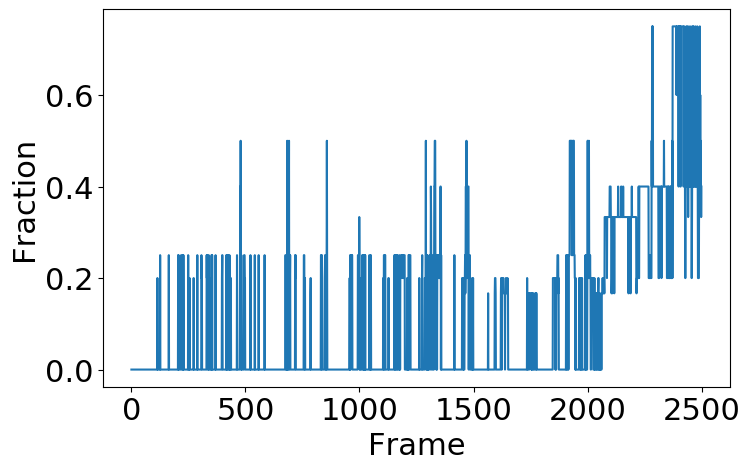

In [400]:
a = pd.DataFrame(range(1, 2501), columns=["Steps"])
t = d_cys.query("Run==3 and Protein=='1fs3' and Submode=='33'").reset_index(drop=True)
t["Steps"] = t["model"] + 1

b = a.merge(t,how="left").fillna(0)
plt.plot(b["fraction"])
plt.xlabel("Frame")
plt.ylabel("Fraction")
plt.savefig("/Users/weilu/Dropbox/openAWSEM/figures/fraction_trajectory_run3_1fs3_33.png", dpi=300, bbox_inches='tight')


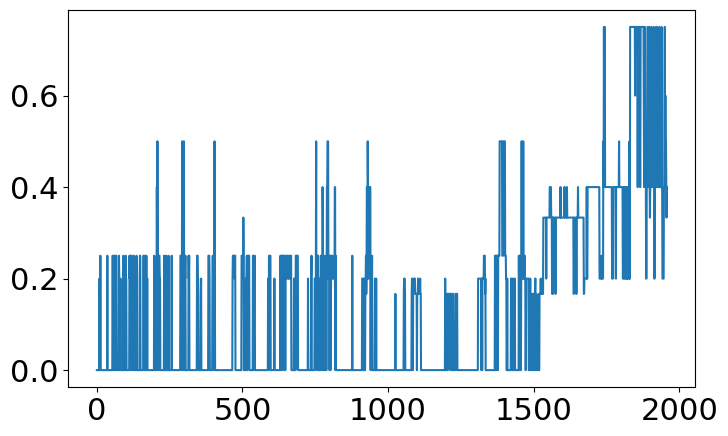

In [237]:
t = d_cys_2.query("Run==3 and Protein=='1fs3' and Submode=='33'").reset_index(drop=True)
plt.plot(t["fraction"])

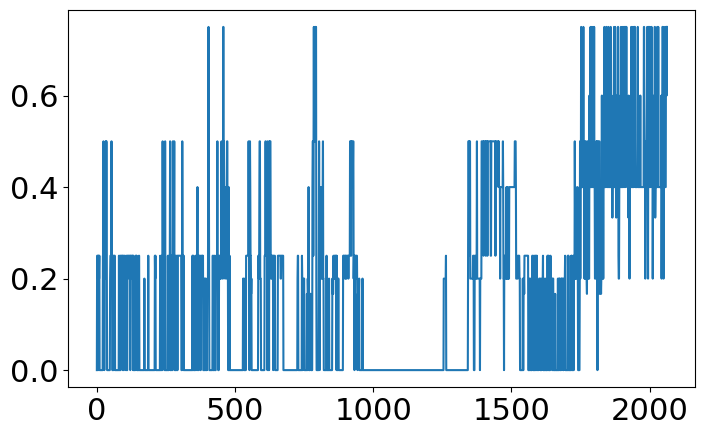

In [242]:
t = d_cys_2.query("Run==12 and Protein=='1fs3' and Submode=='33'").reset_index(drop=True)
plt.plot(t["fraction"])

In [ ]:
# read cys bond information.
selected = data.query("Steps > 1500").sort_values("Q").groupby(["Protein", "Submode"]).tail(1)


# selected = pd.read_csv("/Users/weilu/Research/server/may_week2_2020/disulfide_bond/selected.csv")
fraction = []
for i, line in selected.iterrows():
    run = line["Run"]
    protein = line["Protein"]
    frame = line["Steps"] - 2
    submode = line["Submode"]
    print(run, protein, frame, submode)
    fileLocation = f"/Users/weilu/Research/server/may_week2_2020/disulfide_bond/chosen_frames/{protein}_{submode}.pdb"
    prediction_cys_bond = get_cys_info(fileLocation)
    fileLocation = f"/Users/weilu/Research/server/may_week2_2020/disulfide_bond/setups/{protein}/{protein}.pdb"
    native_cys_bond = get_cys_info(fileLocation)
    TP, FN, FP = correct_fraction(native_cys_bond, prediction_cys_bond)
    fraction.append([TP, FN, FP])

selected = selected.reset_index(drop=True)
fraction_ = pd.DataFrame(fraction, columns=["TP", "FN", "FP"])
selected = pd.concat([selected, fraction_], axis=1)
selected["fraction"] = selected["TP"] / (selected["TP"] + selected["FN"] + selected["FP"])

In [164]:
data.query("model > 2000 and Protein=='1fs3'").sort_values("FP")

,Unnamed: 0,model,Run,Protein,Submode,fraction,TP,FN,FP
503222,28960,2091,1,1fs3,32,1.00,4,0,0
557590,83328,2303,17,1fs3,33,0.75,3,0,1
549628,75366,2299,13,1fs3,33,0.60,3,1,1
555606,81344,2310,16,1fs3,33,0.75,3,0,1
555572,81310,2276,16,1fs3,33,0.50,3,2,1
...,...,...,...,...,...,...,...,...,...
483287,9025,2159,6,1fs3,30,0.00,0,1,4
510990,36728,2071,9,1fs3,32,0.00,0,2,4
510989,36727,2069,9,1fs3,32,0.00,0,2,4
510987,36725,2066,9,1fs3,32,0.00,0,1,4


In [142]:
data.query("model > 2000").sort_values("FP").query("FP == 7")

,Unnamed: 0,model,Run,Protein,Submode,fraction,TP,FN,FP
411427,132335,2238,13,1hn4_A,32,0.0,0,1,7
451845,172753,2396,10,1hn4_A,33,0.0,0,2,7
417876,138784,2216,16,1hn4_A,32,0.0,0,1,7
395949,116857,2188,6,1hn4_A,32,0.0,0,1,7
396023,116931,2262,6,1hn4_A,32,0.0,0,1,7
...,...,...,...,...,...,...,...,...,...
378447,99355,2185,18,1hn4_A,31,0.0,0,1,7
292712,13620,2408,8,1hn4_A,300,0.0,0,1,7
292711,13619,2407,8,1hn4_A,300,0.0,0,1,7
378561,99469,2300,18,1hn4_A,31,0.0,0,1,7


In [ ]:
scheme_dic = {"30":"k_0", "31":"k_1", "32":"k_2", "33":"k_5", "300":"original"}
data["Submode"] = data["Submode"].astype(str)
data["Scheme"] = data["Submode"].apply(lambda x: scheme_dic[x])
data["k_cys"] = data["Scheme"]

In [142]:
# selected = pd.read_csv("/Users/weilu/Research/server/may_week2_2020/disulfide_bond/selected.csv")
fraction = []
for i, line in selected.iterrows():
    run = line["Run"]
    protein = line["Protein"]
    frame = line["Steps"] - 2
    submode = line["Submode"]
    print(run, protein, frame, submode)
    fileLocation = f"/Users/weilu/Research/server/may_week2_2020/disulfide_bond/chosen_frames/{protein}_{submode}.pdb"
    prediction_cys_bond = get_cys_info(fileLocation)
    fileLocation = f"/Users/weilu/Research/server/may_week2_2020/disulfide_bond/setups/{protein}/{protein}.pdb"
    native_cys_bond = get_cys_info(fileLocation)
    TP, FN, FP = correct_fraction(native_cys_bond, prediction_cys_bond)
    fraction.append([TP, FN, FP])

2 1ppb 1569 32
5 1ppb 2457 33
2 1ppb 2187 31
5 1ppb 2172 300
3 1ppb 1890 30
16 1fs3 2066 300
14 1fs3 2114 30
3 1fs3 2431 31
14 1tcg 2332 30
12 1tcg 2140 31
6 1tcg 2322 32
11 1tcg 2361 33
9 1tcg 2028 300
12 1lmm 2362 30
10 1lmm 2479 31
8 1lmm 2295 32
1 1lmm 2025 33
4 1fs3 2149 32
7 1lmm 2146 300
2 1hn4 2270 30
3 1fs3 2414 33
9 1hn4 1990 31
10 1hn4 2281 300
17 1hn4 2062 32
6 1hn4 1977 33
16 1bpi 2392 300
8 1bpi 2164 30
19 1bpi 2347 31
19 1bpi 2444 32
14 1bpi 2213 33


In [157]:
# pdb_list = ["1ppb", "1lmm", "1tcg", "1hn4_A", "1fs3", "1bpi"]
# # pdb_list = ["1ppb", "1lmm", "1tcg", "1hn4_A", "1bpi"]
# for pdb in pdb_list:
#     print(pdb)
#     protein = pdb
#     fileLocation = f"/Users/weilu/Research/server/may_week2_2020/disulfide_bond/setups/{protein}/{protein}.pdb"
#     native_cys_bond = get_cys_info(fileLocation)

#     data_selected = data.query(f"Protein=='{protein}'")
#     result = data_selected[["model", "Run", "Protein", "Submode"]].groupby(["model", "Run", "Protein", "Submode"]).head(1).reset_index(drop=True)
#     result['fraction'], result['TP'], result['FN'], result['FP'] = zip(*data_selected.groupby(["model", "Run", "Protein", "Submode"]).apply(correct_fraction_v2, native_cys_bond).reset_index(drop=True))
#     result.to_csv(f"/Users/weilu/Research/data/openMM/{protein}_cys_05-21.csv")
# pdb_list = ["1ppb", "1lmm", "1tcg", "1hn4_A", "1fs3", "1bpi"]
# d_list =[]
# for pdb in pdb_list:
#     t = pd.read_csv(f"/Users/weilu/Research/data/openMM/{pdb}_cys_05-21.csv")
#     d_list.append(t)
# data = pd.concat(d_list).reset_index(drop=True)
# d_cys = data

# protein = "1fs3"
# fileLocation = f"/Users/weilu/Research/server/may_week2_2020/disulfide_bond/setups/{protein}/{protein}.pdb"
# native_cys_bond = get_cys_info(fileLocation)

# data_selected = data.query(f"Protein=='{protein}'")
# result = data_selected[["model", "Run", "Protein", "Submode"]].groupby(["model", "Run", "Protein", "Submode"]).head(1).reset_index(drop=True)
# result['fraction'], result['TP'], result['FN'], result['FP'] = zip(*data_selected.groupby(["model", "Run", "Protein", "Submode"]).apply(correct_fraction_v2, native_cys_bond).reset_index(drop=True))
# result.to_csv(f"/Users/weilu/Research/data/openMM/{protein}_cys_05-21.csv")

In [159]:
# selected.to_csv("/Users/weilu/Research/data/openMM/six_proteins_run1_ho_05-20.csv")

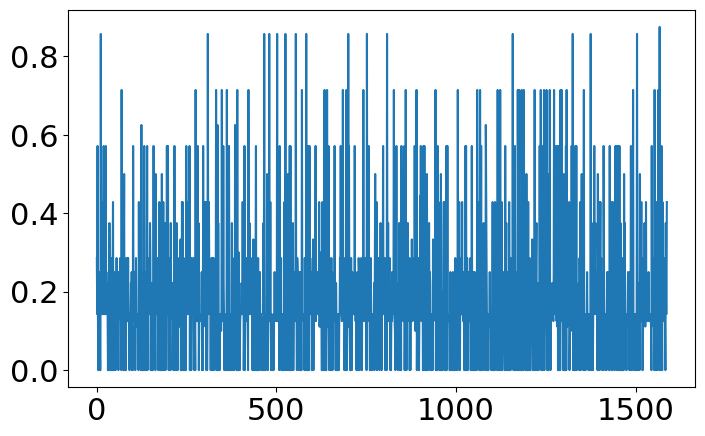

In [151]:
t = data.query("Run==9 and Protein=='1hn4_A' and Submode=='300'").reset_index(drop=True)
plt.plot(t["fraction"])

In [153]:
t.head(20)


,Unnamed: 0,model,Run,Protein,Submode,fraction,TP,FN,FP
0,13673,3,9,1hn4_A,300,0.285714,2,0,5
1,13674,8,9,1hn4_A,300,0.142857,1,0,6
2,13675,11,9,1hn4_A,300,0.571429,4,0,3
3,13676,12,9,1hn4_A,300,0.142857,1,0,6
4,13677,14,9,1hn4_A,300,0.000000,0,1,7
5,13678,24,9,1hn4_A,300,0.111111,1,2,6
6,13679,25,9,1hn4_A,300,0.142857,1,0,6
7,13680,28,9,1hn4_A,300,0.250000,2,1,5
8,13681,30,9,1hn4_A,300,0.142857,1,0,6
9,13682,31,9,1hn4_A,300,0.000000,0,1,7


In [114]:
data.head(10)["Protein"].unique()[0]

'1hn4_A'

In [ ]:
result

In [116]:
result = t[["model", "Run", "Protein", "Submode"]].groupby("model").head(1).reset_index(drop=True)
result['fraction'], result['TP'], result['FN'], result['FP'] = zip(*t.groupby("model").apply(correct_fraction_v2, native_cys_bond).reset_index(drop=True))

In [117]:
result

,model,Run,Protein,Submode,fraction,TP,FN,FP
0,3,3,1fs3,33,0.000000,0,1,4
1,22,3,1fs3,33,0.000000,0,1,4
2,65,3,1fs3,33,0.000000,0,1,4
3,68,3,1fs3,33,0.000000,0,1,4
4,77,3,1fs3,33,0.000000,0,1,4
...,...,...,...,...,...,...,...,...
1953,2495,3,1fs3,33,0.400000,2,1,2
1954,2496,3,1fs3,33,0.500000,3,2,1
1955,2497,3,1fs3,33,0.400000,2,1,2
1956,2498,3,1fs3,33,0.333333,2,2,2


In [52]:
f, TP, FN, FP =  correct_fraction_v2(native_cys_bond, tt)

In [100]:
t.groupby("model").apply(correct_fraction_v2, native_cys_bond).reset_index(drop=True)

0                      (0.0, 0, 1, 4)
1                      (0.0, 0, 1, 4)
2                      (0.0, 0, 1, 4)
3                      (0.0, 0, 1, 4)
4                      (0.0, 0, 1, 4)
                    ...              
1953                   (0.4, 2, 1, 2)
1954                   (0.5, 3, 2, 1)
1955                   (0.4, 2, 1, 2)
1956    (0.3333333333333333, 2, 2, 2)
1957                   (0.4, 2, 1, 2)
Length: 1958, dtype: object

In [ ]:
result.apply()

In [76]:
result = t.groupby("model").apply(correct_fraction_v2, native_cys_bond).reset_index(drop=True)

In [98]:
result

,model,Run,Protein,Submode,fraction,TP,FN,FP
0,3,3,1fs3,33,0.000000,0,1,4
1,22,3,1fs3,33,0.000000,0,1,4
2,65,3,1fs3,33,0.000000,0,1,4
3,68,3,1fs3,33,0.000000,0,1,4
4,77,3,1fs3,33,0.000000,0,1,4
...,...,...,...,...,...,...,...,...
1953,2495,3,1fs3,33,0.400000,2,1,2
1954,2496,3,1fs3,33,0.500000,3,2,1
1955,2497,3,1fs3,33,0.400000,2,1,2
1956,2498,3,1fs3,33,0.333333,2,2,2


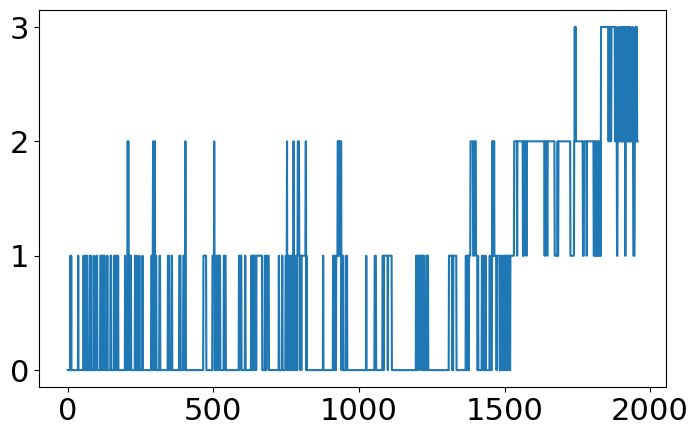

In [101]:
plt.plot(result["TP"])

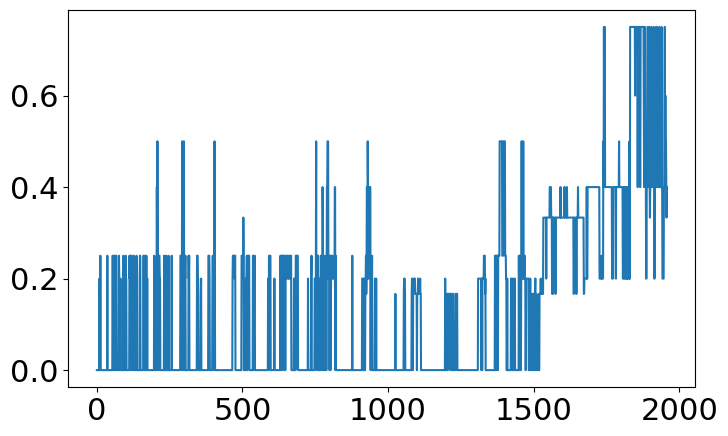

In [99]:
plt.plot(result["fraction"])

In [64]:
result = result.to_frame(name="result")

In [106]:
data

,model,i,j,r,Run,Protein,Submode
0,11,48,49,4.415734,0,1hn4_A,300
1,13,88,100,4.236747,0,1hn4_A,300
2,15,15,48,3.744685,0,1hn4_A,300
3,24,55,102,3.940284,0,1hn4_A,300
4,25,65,102,3.700861,0,1hn4_A,300
...,...,...,...,...,...,...,...
1237625,2497,29,50,3.663368,19,1bpi,33
1237626,2498,13,37,3.453648,19,1bpi,33
1237627,2498,29,54,3.628839,19,1bpi,33
1237628,2499,13,37,3.571851,19,1bpi,33


In [49]:
tt

,model,i,j,r,Run,Protein,Submode,pair
0,2499,25,83,3.519857,3,1fs3,33,25_83
1,2499,39,94,3.707108,3,1fs3,33,39_94
2,2499,71,109,3.992830,3,1fs3,33,71_109


In [320]:
selected = pd.read_csv("/Users/weilu/Research/data/openMM/six_proteins_run1_ho_05-20.csv", index_col=0)

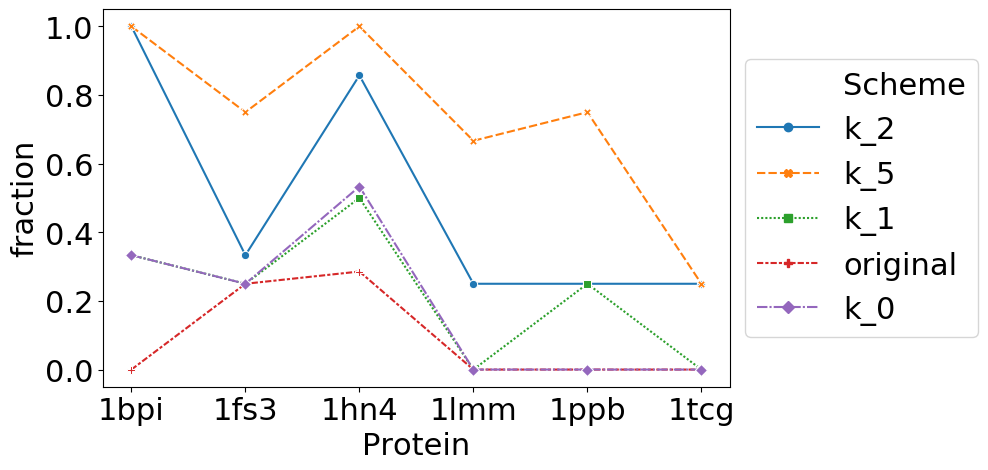

In [174]:
selected = selected.reset_index(drop=True)
fraction_ = pd.DataFrame(fraction, columns=["TP", "FN", "FP"])
selected = pd.concat([selected, fraction_], axis=1)
selected["fraction"] = selected["TP"] / (selected["TP"] + selected["FN"] + selected["FP"])


# selected["Submode"] = selected["Submode"].astype(str)
# # selected["Scheme"] = "mode" + selected["Submode"]
# selected["Scheme"] = selected["Submode"].apply(lambda x: scheme_dic[x])
ax = sns.lineplot("Protein", "fraction", hue="Scheme", style="Scheme", markers=True, data=selected, dashes=True)
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
leg = ax.legend(loc = 'center left', bbox_to_anchor = (1.0, 0.5))
# plt.tight_layout()
plt.savefig("/Users/weilu/Dropbox/openAWSEM/figures/k_cys_fraction.png", dpi=300, bbox_inches='tight')



In [43]:
s = parser.get_structure("X", "/Users/weilu/Research/server/may_week2_2020/disulfide_bond/setups/1lmm/1lmm.pdb")
m = s[0]
all_res = list(m.get_residues())

In [52]:
n = len(all_res)
native_cys_bond = []
for i in range(n):
    res1 = all_res[i]
    if res1.resname != "CYS":
        continue
    for j in range(i+1, n):
        res2 = all_res[j]
        if res2.resname != "CYS":
            continue
        r = res1["CB"] - res2["CB"]
        # print(i, j, r)
        if r < 4.5:
            # print(i, j, r)
            native_cys_bond.append([i, j, r])
native_cys_bond = pd.DataFrame(native_cys_bond, columns=["i", "j", "r"])

In [53]:
native_cys_bond

,i,j,r
0,2,17,3.431250
1,9,22,4.407601
2,16,32,3.717292


In [55]:
s = parser.get_structure("X", "/Users/weilu/Research/server/may_week2_2020/disulfide_bond/run1_ho/1lmm/33_0/lastFrame.pdb")

m = s[0]
all_res = list(m.get_residues())

In [56]:
n = len(all_res)
for i in range(n):
    res1 = all_res[i]
    if res1.resname != "CYS":
        continue
    for j in range(i+1, n):
        res2 = all_res[j]
        if res2.resname != "CYS":
            continue
        r = res1["CB"] - res2["CB"]
        if r < 4.5:
            print(i, j, r)

9 17 3.5390723
22 32 4.0912676


In [98]:
native_cys_bond

,i,j,r
0,2,17,3.431250
1,9,22,4.407601
2,16,32,3.717292


In [80]:
# pdb_list = ["1tt8", "6btc", "6g57", "6q64", "pex22", "sos", "unk2", "6jdq", "5uak"]
pdb_list = ["1hn4_A", "1ppb_H", "1lmm", "1tcg", "1fs3", "1bpi"]
subMode_list = []
# subMode_list += [100, 101, 102, 103, 104, 105, 106]
# subMode_list += [110, 111, 112, 113, 114, 115, 116]
# subMode_list += [120, 121, 122, 123, 124, 125, 126]
# subMode_list += [0, 1, 2, 3, 4, 5]
# subMode_list += [30, 31, 32, 33, 34, 35]
# subMode_list += [1300, 130, 131, 132, 133]
subMode_list += [3300, 330, 331, 332, 333]
# subMode_list += [130, 131, 132, 133, 134, 135] 
simulationType = "six_proteins"
subFolder = "run2_single_timeStep2_lesser_frag"
pre_base = "/Users/weilu/Research/server/jun_week1_2020//disulfide_bond/"
info = []
all_data = []
for pdb in pdb_list:
    for submode in subMode_list:
        for i in range(20):
            pre = f"{pre_base}/{subFolder}/{pdb}/{submode}_{i}"
            location = f"{pre}/info.dat"
            try:
                tmp = pd.read_csv(location, sep="\s+")
                tmp = tmp.assign(Run=i, Protein=pdb, Submode=submode)
                all_data.append(tmp)
            except Exception as e:
                print(pdb, i, submode, location)
                print(e)
                pass
data = pd.concat(all_data, sort=False)

# info = pd.DataFrame(info)

today = datetime.today().strftime('%m-%d')
outFile = f"/Users/weilu/Research/data/openMM/{simulationType}_{subFolder}_{today}.csv"
data.reset_index(drop=True).to_csv(outFile)
print(outFile)

/Users/weilu/Research/data/openMM/six_proteins_run2_single_timeStep2_lesser_frag_06-17.csv


In [28]:
# pdb_list = ["1tt8", "6btc", "6g57", "6q64", "pex22", "sos", "unk2", "6jdq", "5uak"]
pdb_list = ["1hn4_A", "1ppb_H", "1lmm", "1tcg", "1fs3", "1bpi"]
subMode_list = []
# subMode_list += [100, 101, 102, 103, 104, 105, 106]
# subMode_list += [110, 111, 112, 113, 114, 115, 116]
# subMode_list += [120, 121, 122, 123, 124, 125, 126]
# subMode_list += [0, 1, 2, 3, 4, 5]
# subMode_list += [30, 31, 32, 33, 34, 35]
# subMode_list += [1300, 130, 131, 132, 133]
subMode_list += [2300, 230, 231, 232, 233]
# subMode_list += [130, 131, 132, 133, 134, 135] 
simulationType = "six_proteins"
subFolder = "run2_single_timeStep2_less_frag"
pre_base = "/Users/weilu/Research/server/jun_week1_2020//disulfide_bond/"
info = []
all_data = []
for pdb in pdb_list:
    for submode in subMode_list:
        for i in range(20):
            pre = f"{pre_base}/{subFolder}/{pdb}/{submode}_{i}"
            location = f"{pre}/info.dat"
            try:
                tmp = pd.read_csv(location, sep="\s+")
                tmp = tmp.assign(Run=i, Protein=pdb, Submode=submode)
                all_data.append(tmp)
            except Exception as e:
                print(pdb, i, submode, location)
                print(e)
                pass
data = pd.concat(all_data, sort=False)

# info = pd.DataFrame(info)

today = datetime.today().strftime('%m-%d')
outFile = f"/Users/weilu/Research/data/openMM/{simulationType}_{subFolder}_{today}.csv"
data.reset_index(drop=True).to_csv(outFile)
print(outFile)

1ppb_H 1 2300 /Users/weilu/Research/server/jun_week1_2020//disulfide_bond//run2_single_timeStep2_less_frag/1ppb_H/2300_1/info.dat
[Errno 2] File b'/Users/weilu/Research/server/jun_week1_2020//disulfide_bond//run2_single_timeStep2_less_frag/1ppb_H/2300_1/info.dat' does not exist: b'/Users/weilu/Research/server/jun_week1_2020//disulfide_bond//run2_single_timeStep2_less_frag/1ppb_H/2300_1/info.dat'
1lmm 1 230 /Users/weilu/Research/server/jun_week1_2020//disulfide_bond//run2_single_timeStep2_less_frag/1lmm/230_1/info.dat
[Errno 2] File b'/Users/weilu/Research/server/jun_week1_2020//disulfide_bond//run2_single_timeStep2_less_frag/1lmm/230_1/info.dat' does not exist: b'/Users/weilu/Research/server/jun_week1_2020//disulfide_bond//run2_single_timeStep2_less_frag/1lmm/230_1/info.dat'
/Users/weilu/Research/data/openMM/six_proteins_run2_single_timeStep2_less_frag_06-10.csv


In [3]:
# pdb_list = ["1tt8", "6btc", "6g57", "6q64", "pex22", "sos", "unk2", "6jdq", "5uak"]
pdb_list = ["1hn4_A", "1ppb", "1lmm", "1tcg", "1fs3", "1bpi"]
subMode_list = []
# subMode_list += [100, 101, 102, 103, 104, 105, 106]
# subMode_list += [110, 111, 112, 113, 114, 115, 116]
# subMode_list += [120, 121, 122, 123, 124, 125, 126]
# subMode_list += [0, 1, 2, 3, 4, 5]
# subMode_list += [30, 31, 32, 33, 34, 35]
subMode_list += [1300, 130, 131, 132, 133]
# subMode_list += [130, 131, 132, 133, 134, 135] 
simulationType = "six_proteins"
subFolder = "run2_single_timeStep2"
pre_base = "/Users/weilu/Research/server/jun_week1_2020//disulfide_bond/"
info = []
all_data = []
for pdb in pdb_list:
    for submode in subMode_list:
        for i in range(20):
            pre = f"{pre_base}/{subFolder}/{pdb}/{submode}_{i}"
            location = f"{pre}/info.dat"
            try:
                tmp = pd.read_csv(location, sep="\s+")
                tmp = tmp.assign(Run=i, Protein=pdb, Submode=submode)
                all_data.append(tmp)
            except Exception as e:
                print(pdb, i, submode, location)
                print(e)
                pass
data = pd.concat(all_data, sort=False)

# info = pd.DataFrame(info)

today = datetime.today().strftime('%m-%d')
outFile = f"/Users/weilu/Research/data/openMM/{simulationType}_{subFolder}_{today}.csv"
data.reset_index(drop=True).to_csv(outFile)
print(outFile)

/Users/weilu/Research/data/openMM/six_proteins_run2_single_timeStep2_06-06.csv


In [ ]:
pdb_list = ["1ppb", "1lmm", "1tcg", "1hn4_A", "1fs3", "1bpi"]
# pdb_list = ["1ppb", "1lmm", "1tcg", "1hn4_A", "1bpi"]
for pdb in pdb_list:
    print(pdb)
    protein = pdb
    fileLocation = f"/Users/weilu/Research/server/jun_week1_2020//disulfide_bond/setups/{protein}/{protein}.pdb"
    native_cys_bond = get_cys_info(fileLocation)

    data_selected = data_cys.query(f"Protein=='{protein}'")
    result = data_selected.groupby(["model", "Run", "Protein", "Submode"]).apply(correct_fraction_v3, native_cys_bond=native_cys_bond).reset_index()
    result.to_csv(f"/Users/weilu/Research/data/openMM/{protein}_cys_06-06.csv")

In [19]:
# pdb_list = ["1tt8", "6btc", "6g57", "6q64", "pex22", "sos", "unk2", "6jdq", "5uak"]
pdb_list = ["1hn4_A", "1ppb_H", "1ppb", "1lmm", "1tcg", "1hn4", "1fs3", "1bpi"]
subMode_list = []
# subMode_list += [100, 101, 102, 103, 104, 105, 106]
# subMode_list += [110, 111, 112, 113, 114, 115, 116]
# subMode_list += [120, 121, 122, 123, 124, 125, 126]
# subMode_list += [0, 1, 2, 3, 4, 5]
# subMode_list += [30, 31, 32, 33, 34, 35]
subMode_list += [300, 30, 31, 32, 33]
# subMode_list += [130, 131, 132, 133, 134, 135] 
simulationType = "six_proteins"
subFolder = "run1_ho"
pre_base = "/Users/weilu/Research/server/may_week2_2020/disulfide_bond/"
info = []
all_data = []
for pdb in pdb_list:
    for submode in subMode_list:
        for i in range(20):
            pre = f"{pre_base}/{subFolder}/{pdb}/{submode}_{i}"
            location = f"{pre}/info.dat"
            try:
                tmp = pd.read_csv(location, sep="\s+")
                tmp = tmp.assign(Run=i, Protein=pdb, Submode=submode)
                all_data.append(tmp)
            except Exception as e:
                print(pdb, i, submode, location)
                print(e)
                pass
data = pd.concat(all_data, sort=False)

# info = pd.DataFrame(info)

today = datetime.today().strftime('%m-%d')
outFile = f"/Users/weilu/Research/data/openMM/{simulationType}_{subFolder}_{today}.csv"
data.reset_index(drop=True).to_csv(outFile)
print(outFile)

/Users/weilu/Research/data/openMM/six_proteins_run1_ho_05-21.csv


In [ ]:
a = pd.read_csv("/Users/weilu/Research/data/openMM/length_info_12-01.csv", index_col=0)
data = data.merge(a, on="Protein")

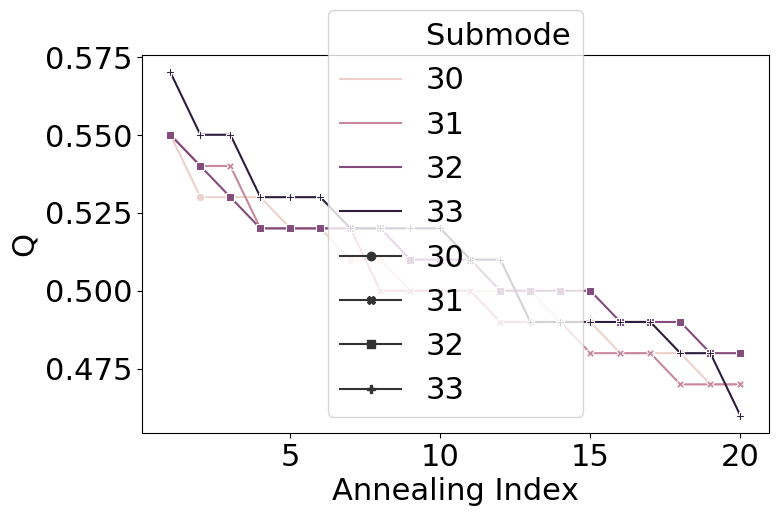

In [17]:
filtered_data = data.query("Steps > 1500 and Protein == '1lmm'")
Q_max = filtered_data.sort_values('Q').groupby(["Submode", "Run"]).tail(1).sort_values(['Submode', "Q"])
Q_max["Annealing Index"] = Q_max.groupby(["Submode"])["Q"].rank(method="first", ascending=False).astype(int)
sns.lineplot("Annealing Index", "Q", hue="Submode", markers=True, data=Q_max, style="Submode", dashes=False)

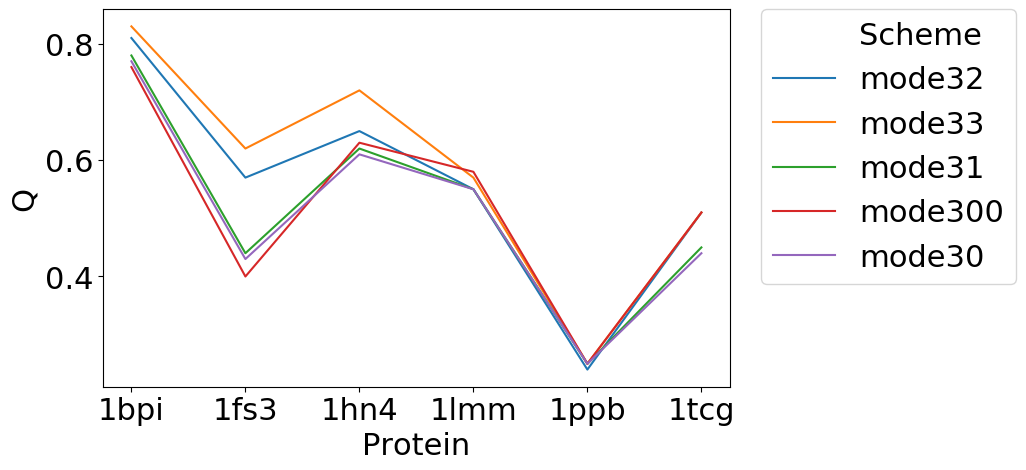

In [88]:
selected = data.query("Steps > 1500").sort_values("Q").groupby(["Protein", "Submode"]).tail(1)
selected["Submode"] = selected["Submode"].astype(str)
selected["Scheme"] = "mode" + selected["Submode"]
ax = sns.lineplot("Protein", "Q", hue="Scheme", markers=True, data=selected, dashes=False)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


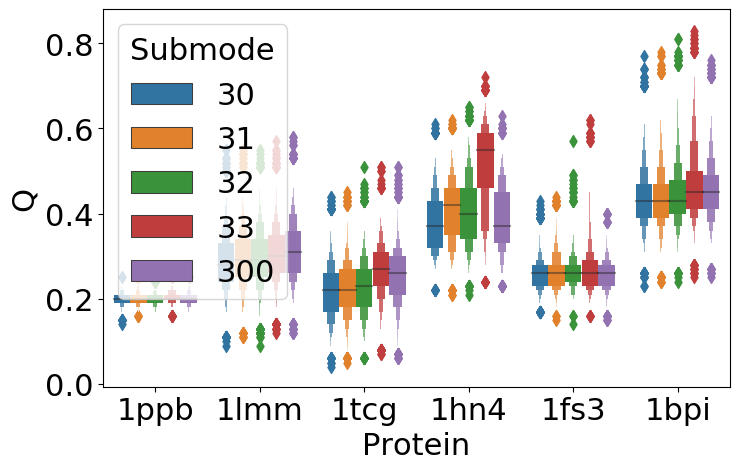

In [74]:
selected = data.query("Steps > 1500")
sns.boxenplot("Protein", "Q", hue="Submode", data=selected)

In [ ]:
selected.to_csv("/Users/weilu/Research/server/may_week2_2020/disulfide_bond/selected.csv")

In [ ]:

memory = 'ho'
filtered_data = data.query(f"memory == '{memory}'").query("k_cys != 'k_10' and k_cys != 'k_20'")
# filtered_data = data.query(f"Protein == '{protein}'").query(f"memory == '{memory}'").query("k_cys != 'k_10' and k_cys != 'k_20'")
Q_max = filtered_data.sort_values('Q').groupby(["Submode", "Protein"]).tail(1).sort_values(['Submode', "Q"])
Q_max.Protein = pd.Categorical(Q_max.Protein, a.sort_values("Length").Protein.values)
Q_max.k_cys = pd.Categorical(Q_max.k_cys, ["k_0", "k_1", "k_2", "k_5"])
# Q_max["Annealing Index"] = Q_max.groupby(["Submode"])["Q"].rank(method="first", ascending=False).astype(int)
# last = data.query("Steps > 350 and Folder in ['eighth_2_cys']")

# sns.lineplot("Annealing Index", "Q", markers=True, style="k_cys", data=Q_max, hue="k_cys", dashes=False)
sns.lineplot("Protein", "Q", hue="k_cys", markers=True, data=Q_max.sort_values("Length").reset_index(drop=True), style="k_cys", dashes=False)
plt.ylabel("Best Q")
# _ = plt.xticks(np.arange(1, 21, 1))
plt.title(f"structure prediction results of 5 Disufide rich proteins")
# plt.savefig("/Users/weilu/Dropbox/openAWSEM/figures/k_cys_original_gamma.png", dpi=300)

In [28]:
a = np.load("/Users/weilu/Research/server/may_week3_2020/T1024/T1024.npz")

In [33]:
a["dist"].shape

(408, 408, 37)

In [31]:
b = np.load("/Users/weilu/Research/server/may_week3_2020/T1024/dist.npz")

In [34]:
b["distspline"].shape

(408, 408, 35)

In [ ]:
def get_frame(file="movie.pdb", to="last_frame.pdb", frame=-1):
    # default is last frame.
    # if you want first, please set frame to 1.
    a = open(file).read().split("ENDMDL")
    assert a[-1] == "\nEND\n"
    with open(to, "w") as out:
        out.write(a[frame-1])



In [31]:
# read all cys information.
# pdb_list = ["1tt8", "6btc", "6g57", "6q64", "pex22", "sos", "unk2", "6jdq", "5uak"]
pdb_list = ["1hn4_A", "1ppb_H", "1lmm", "1tcg", "1fs3", "1bpi"]
subMode_list = []
# subMode_list += [100, 101, 102, 103, 104, 105, 106]
# subMode_list += [110, 111, 112, 113, 114, 115, 116]
# subMode_list += [120, 121, 122, 123, 124, 125, 126]
# subMode_list += [0, 1, 2, 3, 4, 5]
# subMode_list += [30, 31, 32, 33, 34, 35]
# subMode_list += [300, 30, 31, 32, 33]
subMode_list += [3300, 330, 331, 332, 333]
# subMode_list += [130, 131, 132, 133, 134, 135] 
simulationType = "six_proteins"
subFolder = "run2_single_timeStep2_lesser_frag"
pre_base = "/Users/weilu/Research/server/jun_week1_2020/disulfide_bond/"
info = []
all_data = []
for pdb in pdb_list:
    for submode in subMode_list:
        for i in range(15):
            pre = f"{pre_base}/{subFolder}/{pdb}/{submode}_{i}"
            location = f"{pre}/cys_bonds.csv"
            try:
                tmp = pd.read_csv(location, index_col=0)
                tmp = tmp.assign(Run=i, Protein=pdb, Submode=submode)
                all_data.append(tmp)
            except Exception as e:
                print(pdb, i, submode, location)
                print(e)
                pass
data = pd.concat(all_data, sort=False)

# info = pd.DataFrame(info)

today = datetime.today().strftime('%m-%d')
outFile = f"/Users/weilu/Research/data/openMM/{simulationType}_{subFolder}_{today}.csv"
data.reset_index(drop=True).to_csv(outFile)
print(outFile)

/Users/weilu/Research/data/openMM/six_proteins_run2_single_timeStep2_lesser_frag_06-16.csv


In [79]:
# read all cys information.
# pdb_list = ["1tt8", "6btc", "6g57", "6q64", "pex22", "sos", "unk2", "6jdq", "5uak"]
pdb_list = ["1hn4_A", "1ppb_H", "1lmm", "1tcg", "1fs3", "1bpi"]
subMode_list = []
# subMode_list += [100, 101, 102, 103, 104, 105, 106]
# subMode_list += [110, 111, 112, 113, 114, 115, 116]
# subMode_list += [120, 121, 122, 123, 124, 125, 126]
# subMode_list += [0, 1, 2, 3, 4, 5]
# subMode_list += [30, 31, 32, 33, 34, 35]
# subMode_list += [300, 30, 31, 32, 33]
subMode_list += [3300, 330, 331, 332, 333]
# subMode_list += [130, 131, 132, 133, 134, 135] 
simulationType = "cys_all"
subFolder = "run2_single_timeStep2_lesser_frag"
pre_base = "/Users/weilu/Research/server/jun_week1_2020/disulfide_bond/"
info = []
all_data = []
for pdb in pdb_list:
    for submode in subMode_list:
        for i in range(20):
            pre = f"{pre_base}/{subFolder}/{pdb}/{submode}_{i}"
            location = f"{pre}/cys_bonds.csv"
            try:
                tmp = pd.read_csv(location, index_col=0)
                tmp = tmp.assign(Run=i, Protein=pdb, Submode=submode)
                all_data.append(tmp)
            except Exception as e:
                print(pdb, i, submode, location)
                print(e)
                pass
data = pd.concat(all_data, sort=False)

# info = pd.DataFrame(info)

today = datetime.today().strftime('%m-%d')
outFile = f"/Users/weilu/Research/data/openMM/{simulationType}_{subFolder}_{today}.csv"
data.reset_index(drop=True).to_csv(outFile)
print(outFile)

/Users/weilu/Research/data/openMM/cys_all_run2_single_timeStep2_lesser_frag_06-17.csv
